# medMNIST exploration

In [2]:
import medmnist
print(medmnist.__version__)

3.0.2


In [3]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [5]:
# show my GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# check if GPU is available
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / (1024 ** 3):.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved(0) / (1024 ** 3):.2f} GB")
else:
    print("No GPU available, using CPU instead.")


Using device: cuda
GPU name: NVIDIA GeForce GTX 1080 Ti
GPU memory allocated: 0.00 GB
GPU memory cached: 0.00 GB


In [6]:
# read in the PneumoniaMNIST dataset
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True, size=224)
test_dataset = PneumoniaMNIST(split='test', download=True, size=224)
val_dataset = PneumoniaMNIST(split='val', download=True, size=224)
# print the dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 4708
Number of test samples: 624


In [7]:
print(type(train_dataset[0]))
print(len(train_dataset[0]))
image, label = train_dataset[0]
print(type(image))


<class 'tuple'>
2
<class 'PIL.Image.Image'>


In [8]:
from matplotlib import pyplot as plt

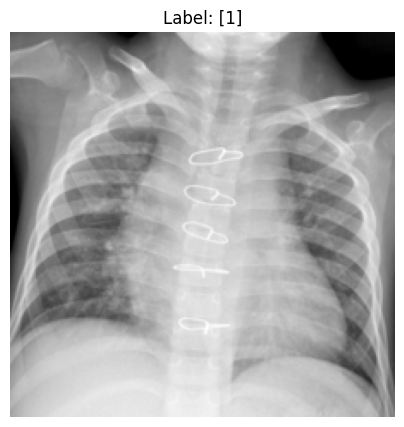

In [9]:
# print 1st 10 samples
for i in range(1):
    image, label = train_dataset[i]
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray' if image.mode == 'L' else None)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide the axes
    plt.show()

In [10]:
# number of samples of each class
postive_count = sum(1 for _, label in train_dataset if label == 1)
negative_count = sum(1 for _, label in train_dataset if label == 0)
print(f"Number of positive samples: {postive_count}")
print(f"Number of negative samples: {negative_count}")

Number of positive samples: 3494
Number of negative samples: 1214


In [11]:
info =INFO['pneumoniamnist']
print(info)
n_channels = info['n_channels']
n_classes = info['label']
print("Number of channels:",n_channels)
print("Number of classes",n_classes)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [12]:
dataiter = iter(train_dataset)
image, label = next(dataiter)
print(image.size)
print(label.shape)

(224, 224)
(1,)


### Hyperparameters
* BATCH_SIZE
* LEARNING_RATE
* NUM_EPOCHS
* IMAGE_SIZE
* NUM_CLASSES
* NUM_CHANNELS

### Data transformations
* Transform to tensor
* Normalize

### Create the dataloaders


In [13]:
BATCH_SIZE = 32
LEARNING_RATE = 0.01
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

dataiter = iter(train_loader)
image, label = next(dataiter)
print(image.shape)
print(label.shape)



Train dataset size: 4708
Test dataset size: 624
Validation dataset size: 524
torch.Size([32, 1, 224, 224])
torch.Size([32, 1])


### Create the SequentialNN classifier class

In [38]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 224x224 -> 112x112
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 112x112 -> 56x56
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 56x56 -> 28x28
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # Calculate the flattened size dynamically (or pre-calculate)
        # After 4 pooling layers (2x2 stride), the size is 224 / (2^4) = 224 / 16 = 14
        # Flattened size = channels * height * width = 256 * 14 * 14
        self.flattened_size = 256 * 14 * 14

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.fc2(x) # Output raw logits
        return x


In [39]:
# Instantiate the model and move it to the device
model_orig = SimpleCNN(in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES).to(device)
print(model_orig)

# Optional: Print model summary (requires torchsummary)
from torchsummary import summary
summary(model_orig, (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu_fc): ReLU()
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)
-----------------------------

In [29]:
import torchmetrics

In [40]:
# Loss function
# BCEWithLogitsLoss combines Sigmoid layer and BCELoss in one single class.
# It's more numerically stable than using a plain Sigmoid followed by BCELoss.
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model_orig.parameters(), lr=LEARNING_RATE)

# Metrics using torchmetrics (more robust than manual calculation)
# We need 'BinaryAccuracy' and potentially 'BinaryAUROC' for binary tasks.
# Make sure to move metrics objects to the correct device.
train_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
val_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
val_auc_metric = torchmetrics.AUROC(task="binary").to(device)
roc_metric = torchmetrics.ROC(task="binary").to(device)

### Understanding of each dataset
* Training Set: Used directly by the optimizer to learn the model parameters (weights and biases). The model sees these examples and their labels repeatedly. Performance on this set indicates how well the model is fitting the data it's learning from.
* Validation Set: Used during the training process (typically after each epoch) to evaluate the model's generalization ability on data it hasn't been trained on. This helps in:
* - Monitoring for overfitting (training performance improves, validation performance stagnates or degrades).
* - Hyperparameter tuning (e.g., choosing the best learning rate, network architecture).
* - Early stopping (stopping training when validation performance stops improving).
* Test Set: Used only once after the final model (chosen based on validation performance and finalized hyperparameters) has been trained. It provides an unbiased estimate of the model's performance on completely unseen data, simulating real-world performance.

In [31]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, accuracy_metric):
    model.train()  # Set model to training mode (enables dropout/batchnorm updates)
    running_loss = 0.0
    accuracy_metric.reset() # Reset metric at the start of epoch

    # Use tqdm for a progress bar
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device)
        # Labels need to be float and match the output shape for BCEWithLogitsLoss
        # Original labels might be Long, convert to Float.
        # The output of the model is [batch_size, 1], labels should be [batch_size, 1] or [batch_size]
        #labels = labels.float().unsqueeze(1).to(device) # Add dimension if necessary
        labels = labels.float().to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs) # Shape: [batch_size, 1] (logits)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0) # loss.item() is avg loss per batch

        # Update metrics (expects probabilities or logits)
        # Pass outputs directly (logits) or torch.sigmoid(outputs) (probabilities)
        accuracy_metric.update(outputs, labels.int()) # Accuracy metric often needs integer labels

        # Update progress bar description
        if (i + 1) % 50 == 0 or i == len(loader) - 1:
             progress_bar.set_postfix(loss=loss.item(), acc=accuracy_metric.compute().item())


    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_metric.compute()
    print(f"Epoch {epoch+1} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc



In [32]:
def validate_one_epoch(model, loader, criterion, device, accuracy_metric, auc_metric, roc_metric):
    model.eval()   # Set model to evaluation mode (disables dropout/batchnorm updates)
    running_loss = 0.0
    accuracy_metric.reset()
    auc_metric.reset()
    roc_metric.reset()

    progress_bar = tqdm(loader, desc="           [Validate]", leave=False)

    with torch.no_grad(): # Disable gradient calculations for validation
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            #labels = labels.float().unsqueeze(1).to(device) # Ensure float and correct shape
            labels = labels.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Update metrics
            accuracy_metric.update(outputs, labels.int())
            auc_metric.update(outputs, labels.int()) # AUC metric also needs integer labels
            roc_metric.update(outputs, labels.int())

            progress_bar.set_postfix(loss=loss.item(), acc=accuracy_metric.compute().item(), auc=auc_metric.compute().item())


    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_metric.compute()
    epoch_auc = auc_metric.compute()
    epoch_roc = roc_metric.compute() # Get ROC curve (if needed)
    print(f"         Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC: {epoch_auc:.4f}")
    return epoch_loss, epoch_acc, epoch_auc, epoch_roc



In [33]:

def test_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    # Use fresh metric instances for testing
    test_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
    test_auc_metric = torchmetrics.AUROC(task="binary").to(device)
    # Add other relevant metrics if needed (Precision, Recall, F1)
    test_precision_metric = torchmetrics.Precision(task="binary").to(device)
    test_recall_metric = torchmetrics.Recall(task="binary").to(device)
    test_f1_metric = torchmetrics.F1Score(task="binary").to(device)
    test_roc_metric = torchmetrics.ROC(task="binary").to(device)

    print("\nStarting Testing...")
    progress_bar = tqdm(loader, desc="[Test]", leave=False)

    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            #labels = labels.float().unsqueeze(1).to(device)
            labels = labels.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Update all test metrics
            int_labels = labels.int()
            test_accuracy_metric.update(outputs, int_labels)
            test_auc_metric.update(outputs, int_labels)
            test_precision_metric.update(outputs, int_labels)
            test_recall_metric.update(outputs, int_labels)
            test_f1_metric.update(outputs, int_labels)
            test_roc_metric.update(outputs, int_labels)

    test_loss = running_loss / len(loader.dataset)
    test_acc = test_accuracy_metric.compute()
    test_auc = test_auc_metric.compute()
    test_precision = test_precision_metric.compute()
    test_recall = test_recall_metric.compute()
    test_f1 = test_f1_metric.compute()
    test_roc = test_roc_metric.compute() # Get ROC curve if needed


    print("\n--- Test Results ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print("--------------------")


    # It's good practice to clean up metric states
    test_accuracy_metric.reset()
    test_auc_metric.reset()
    test_precision_metric.reset()
    test_recall_metric.reset()
    test_f1_metric.reset()
    test_roc_metric.reset()

    return test_roc



In [34]:
# --- Placeholder for storing history ---
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_aucs = [] # Store validation AUC
val_rocs = [] # Store validation ROC

In [41]:
# --- Main Training Execution ---
NUM_EPOCHS = 2
print("\nStarting Training...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model_orig, train_loader, criterion, optimizer, device, epoch, train_accuracy_metric)
    val_loss, val_acc, val_auc, val_roc = validate_one_epoch(model_orig, val_loader, criterion, device, val_accuracy_metric, val_auc_metric, roc_metric)

    # Store metrics for plotting later
    train_losses.append(train_loss)
    train_accs.append(train_acc.item()) # Get scalar value from tensor
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())
    val_aucs.append(val_auc.item())
    val_rocs.append(val_roc) # Store ROC curve if needed

print("Training Finished!")


Starting Training...


Epoch 1 Train Loss: 2.2872 Acc: 0.8250


         Validation Loss: 0.1457 Acc: 0.9466 AUC: 0.9832


Epoch 2 Train Loss: 0.1836 Acc: 0.9299


         Validation Loss: 0.1764 Acc: 0.9351 AUC: 0.9833
Training Finished!


In [42]:
# Run testing
test_roc = test_model(model_orig, test_loader, criterion, device)


Starting Testing...



--- Test Results ---
Test Loss: 0.6477
Test Accuracy: 0.7660
Test AUC: 0.9177
Test Precision: 0.7276
Test Recall: 1.0000
Test F1-Score: 0.8423
--------------------


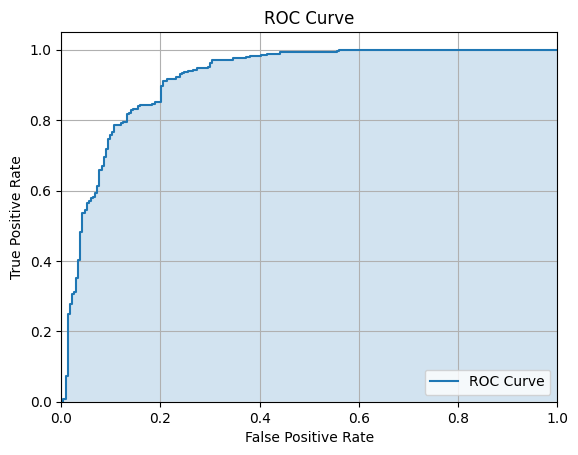

In [43]:
#plot the roc curve
import matplotlib.pyplot as plt
plt.figure
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(test_roc[0].cpu(), test_roc[1].cpu(), label="ROC Curve")
plt.fill_between(test_roc[0].cpu(), test_roc[1].cpu(), alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower right")
plt.show()


## Cost sensitive learning implementation

* Create a variable that will give the number of classifiers
* Weights are between 0.001 to 0.999
* calculate pos_weight to be used with the BCE loss function

In [25]:
NUM_CLASSIFIERS = 500
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)


* loop throught the pos_weights and train NUM_CLASSIFIER classifiers

In [26]:
from sklearn.metrics import confusion_matrix

fpr_weighted = []
tpr_weighted = []

for pos_weight in pos_weights:
    print(f"Positive weight: {pos_weight:.3f}")
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    model = SimpleCNN(in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train and validate the model
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, train_accuracy_metric)
        val_loss, val_acc, val_auc, val_roc = validate_one_epoch(model, val_loader, criterion, device, val_accuracy_metric, val_auc_metric, roc_metric)

   # Manual Inference and Metric Calculation
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"[Test - pos_weight={pos_weight:.3f}]", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float() #Binary predictions
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    #Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    tn, fp, fn, tp = cm.ravel()
    test_accuracy = (tp + tn) / (tp + tn + fp + fn)
    test_precision = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
    test_recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else float('nan')
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    #Calculate FPR and TPR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else float('nan')
    tpr = tp / (tp + fn) if (tp + fn) > 0 else float('nan')

    fpr_weighted.append(fpr)
    tpr_weighted.append(tpr)





Positive weight: 0.001


Epoch 1 Train Loss: 0.0515 Acc: 0.2664


         Validation Loss: 0.0079 Acc: 0.2576 AUC: 0.8763


Epoch 2 Train Loss: 0.0129 Acc: 0.2676


         Validation Loss: 0.0051 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.003


Epoch 1 Train Loss: 0.0452 Acc: 0.3042


         Validation Loss: 0.0189 Acc: 0.2576 AUC: 0.7536


Epoch 2 Train Loss: 0.0109 Acc: 0.2855


         Validation Loss: 0.0073 Acc: 0.2786 AUC: 0.9577


Test Accuracy: 0.3942
Test Precision: 0.9286
Test Recall: 0.0333
Test F1-Score: 0.0644
Positive weight: 0.005


Epoch 1 Train Loss: 0.0847 Acc: 0.2984


         Validation Loss: 0.0167 Acc: 0.2576 AUC: 0.8845


Epoch 2 Train Loss: 0.0132 Acc: 0.2974


         Validation Loss: 0.0079 Acc: 0.4256 AUC: 0.9854


Test Accuracy: 0.5673
Test Precision: 0.9839
Test Recall: 0.3128
Test F1-Score: 0.4747
Positive weight: 0.007


Epoch 1 Train Loss: 0.1090 Acc: 0.2759


         Validation Loss: 0.0270 Acc: 0.2576 AUC: 0.4972


Epoch 2 Train Loss: 0.0259 Acc: 0.2579


         Validation Loss: 0.0257 Acc: 0.2576 AUC: 0.5041


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.009


Epoch 1 Train Loss: 0.3148 Acc: 0.2749


         Validation Loss: 0.0335 Acc: 0.2576 AUC: 0.4946


Epoch 2 Train Loss: 0.0325 Acc: 0.2579


         Validation Loss: 0.0326 Acc: 0.2576 AUC: 0.5054


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.011


Epoch 1 Train Loss: 0.1505 Acc: 0.2676


         Validation Loss: 0.0383 Acc: 0.2576 AUC: 0.3190


Epoch 2 Train Loss: 0.0372 Acc: 0.2579


         Validation Loss: 0.0368 Acc: 0.2576 AUC: 0.4414


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.013


Epoch 1 Train Loss: 0.1604 Acc: 0.3023


         Validation Loss: 0.0423 Acc: 0.2576 AUC: 0.8787


Epoch 2 Train Loss: 0.0423 Acc: 0.2579


         Validation Loss: 0.0433 Acc: 0.2576 AUC: 0.8152


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.015


Epoch 1 Train Loss: 0.2450 Acc: 0.4756


         Validation Loss: 0.0357 Acc: 0.3721 AUC: 0.9502


Epoch 2 Train Loss: 0.0165 Acc: 0.7266


         Validation Loss: 0.0135 Acc: 0.7271 AUC: 0.9819


Test Accuracy: 0.7869
Test Precision: 0.9477
Test Recall: 0.6974
Test F1-Score: 0.8035
Positive weight: 0.017


Epoch 1 Train Loss: 0.1948 Acc: 0.3025


         Validation Loss: 0.5539 Acc: 0.8130 AUC: 0.7786


Epoch 2 Train Loss: 0.0517 Acc: 0.2627


         Validation Loss: 0.0451 Acc: 0.2576 AUC: 0.8238


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.019


Epoch 1 Train Loss: 0.3686 Acc: 0.5501


         Validation Loss: 0.0338 Acc: 0.5076 AUC: 0.9624


Epoch 2 Train Loss: 0.0212 Acc: 0.7213


         Validation Loss: 0.0213 Acc: 0.6260 AUC: 0.9778


Test Accuracy: 0.6811
Test Precision: 0.9614
Test Recall: 0.5103
Test F1-Score: 0.6667
Positive weight: 0.021


Epoch 1 Train Loss: 0.3938 Acc: 0.2719


         Validation Loss: 0.0535 Acc: 0.2576 AUC: 0.8143


Epoch 2 Train Loss: 0.0356 Acc: 0.5433


         Validation Loss: 0.0290 Acc: 0.7500 AUC: 0.9583


Test Accuracy: 0.7756
Test Precision: 0.9340
Test Recall: 0.6897
Test F1-Score: 0.7935
Positive weight: 0.024


Epoch 1 Train Loss: 0.3009 Acc: 0.2600


         Validation Loss: 0.0651 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.0652 Acc: 0.2579


         Validation Loss: 0.0651 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.026


Epoch 1 Train Loss: 0.2817 Acc: 0.4934


         Validation Loss: 0.0210 Acc: 0.7653 AUC: 0.9822


Epoch 2 Train Loss: 0.0394 Acc: 0.6814


         Validation Loss: 0.0449 Acc: 0.5515 AUC: 0.9732


Test Accuracy: 0.6458
Test Precision: 0.9617
Test Recall: 0.4513
Test F1-Score: 0.6143
Positive weight: 0.028


Epoch 1 Train Loss: 0.5967 Acc: 0.2751


         Validation Loss: 0.0734 Acc: 0.2576 AUC: 0.4963


Epoch 2 Train Loss: 0.0735 Acc: 0.2579


         Validation Loss: 0.0735 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.030


Epoch 1 Train Loss: 0.2819 Acc: 0.5079


         Validation Loss: 0.0230 Acc: 0.8034 AUC: 0.9785


Epoch 2 Train Loss: 0.0276 Acc: 0.7799


         Validation Loss: 0.0223 Acc: 0.8244 AUC: 0.9808


Test Accuracy: 0.8253
Test Precision: 0.9219
Test Recall: 0.7872
Test F1-Score: 0.8492
Positive weight: 0.032


Epoch 1 Train Loss: 0.4038 Acc: 0.3320


         Validation Loss: 0.1071 Acc: 0.5954 AUC: 0.8808


Epoch 2 Train Loss: 0.0416 Acc: 0.6079


         Validation Loss: 0.0303 Acc: 0.6412 AUC: 0.9776


Test Accuracy: 0.7196
Test Precision: 0.9536
Test Recall: 0.5795
Test F1-Score: 0.7209
Positive weight: 0.034


Epoch 1 Train Loss: 0.2099 Acc: 0.5790


         Validation Loss: 0.0232 Acc: 0.7748 AUC: 0.9866


Epoch 2 Train Loss: 0.1447 Acc: 0.3435


         Validation Loss: 0.0789 Acc: 0.2576 AUC: 0.8153


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.036


Epoch 1 Train Loss: 0.3255 Acc: 0.3779


         Validation Loss: 0.0438 Acc: 0.3321 AUC: 0.9576


Epoch 2 Train Loss: 0.0366 Acc: 0.6931


         Validation Loss: 0.0408 Acc: 0.9046 AUC: 0.9753


Test Accuracy: 0.8526
Test Precision: 0.8371
Test Recall: 0.9487
Test F1-Score: 0.8894
Positive weight: 0.038


Epoch 1 Train Loss: 0.2514 Acc: 0.5760


         Validation Loss: 0.0416 Acc: 0.6202 AUC: 0.9586


Epoch 2 Train Loss: 0.0299 Acc: 0.8018


         Validation Loss: 0.0355 Acc: 0.7634 AUC: 0.9718


Test Accuracy: 0.7965
Test Precision: 0.9398
Test Recall: 0.7205
Test F1-Score: 0.8157
Positive weight: 0.041


Epoch 1 Train Loss: 0.2906 Acc: 0.5786


         Validation Loss: 0.0467 Acc: 0.8836 AUC: 0.9703


Epoch 2 Train Loss: 0.0411 Acc: 0.7604


         Validation Loss: 0.0343 Acc: 0.7977 AUC: 0.9818


Test Accuracy: 0.8301
Test Precision: 0.9104
Test Recall: 0.8077
Test F1-Score: 0.8560
Positive weight: 0.043


Epoch 1 Train Loss: 0.4383 Acc: 0.3887


         Validation Loss: 0.0439 Acc: 0.7824 AUC: 0.9659


Epoch 2 Train Loss: 0.0346 Acc: 0.7766


         Validation Loss: 0.0293 Acc: 0.8111 AUC: 0.9821


Test Accuracy: 0.8141
Test Precision: 0.9053
Test Recall: 0.7846
Test F1-Score: 0.8407
Positive weight: 0.045


Epoch 1 Train Loss: 1.4049 Acc: 0.4868


         Validation Loss: 0.0438 Acc: 0.5687 AUC: 0.9734


Epoch 2 Train Loss: 0.0827 Acc: 0.6085


         Validation Loss: 0.1099 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.047


Epoch 1 Train Loss: 0.5891 Acc: 0.2787


         Validation Loss: 0.0872 Acc: 0.2576 AUC: 0.8405


Epoch 2 Train Loss: 0.0442 Acc: 0.7336


         Validation Loss: 0.0341 Acc: 0.8149 AUC: 0.9765


Test Accuracy: 0.8269
Test Precision: 0.9222
Test Recall: 0.7897
Test F1-Score: 0.8508
Positive weight: 0.049


Epoch 1 Train Loss: 1.1214 Acc: 0.2617


         Validation Loss: 0.1129 Acc: 0.2576 AUC: 0.5054


Epoch 2 Train Loss: 0.1127 Acc: 0.2579


         Validation Loss: 0.1120 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.052


Epoch 1 Train Loss: 0.4311 Acc: 0.4715


         Validation Loss: 0.0480 Acc: 0.8817 AUC: 0.9691


Epoch 2 Train Loss: 0.0688 Acc: 0.8001


         Validation Loss: 0.0435 Acc: 0.7595 AUC: 0.9799


Test Accuracy: 0.8285
Test Precision: 0.9579
Test Recall: 0.7590
Test F1-Score: 0.8469
Positive weight: 0.054


Epoch 1 Train Loss: 0.3617 Acc: 0.6368


         Validation Loss: 0.0458 Acc: 0.7653 AUC: 0.9830


Epoch 2 Train Loss: 0.0448 Acc: 0.8082


         Validation Loss: 0.0462 Acc: 0.7653 AUC: 0.9720


Test Accuracy: 0.7917
Test Precision: 0.9305
Test Recall: 0.7205
Test F1-Score: 0.8121
Positive weight: 0.056


Epoch 1 Train Loss: 0.3873 Acc: 0.2681


         Validation Loss: 0.1011 Acc: 0.2576 AUC: 0.8246


Epoch 2 Train Loss: 0.0583 Acc: 0.6349


         Validation Loss: 0.0415 Acc: 0.8111 AUC: 0.9822


Test Accuracy: 0.8317
Test Precision: 0.9130
Test Recall: 0.8077
Test F1-Score: 0.8571
Positive weight: 0.058


Epoch 1 Train Loss: 0.8842 Acc: 0.4779


         Validation Loss: 0.0626 Acc: 0.6450 AUC: 0.9752


Epoch 2 Train Loss: 0.0782 Acc: 0.6655


         Validation Loss: 0.1572 Acc: 0.8893 AUC: 0.9171


Test Accuracy: 0.7756
Test Precision: 0.7694
Test Recall: 0.9154
Test F1-Score: 0.8361
Positive weight: 0.060


Epoch 1 Train Loss: 0.4633 Acc: 0.3014


         Validation Loss: 0.1275 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.1271 Acc: 0.2579


         Validation Loss: 0.1270 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.063


Epoch 1 Train Loss: 0.6798 Acc: 0.6899


         Validation Loss: 0.2045 Acc: 0.5286 AUC: 0.9537


Epoch 2 Train Loss: 0.0461 Acc: 0.8345


         Validation Loss: 0.0342 Acc: 0.9103 AUC: 0.9851


Test Accuracy: 0.8494
Test Precision: 0.8524
Test Recall: 0.9179
Test F1-Score: 0.8840
Positive weight: 0.065


Epoch 1 Train Loss: 0.5917 Acc: 0.3078


         Validation Loss: 0.1333 Acc: 0.2576 AUC: 0.4946


Epoch 2 Train Loss: 0.1338 Acc: 0.2579


         Validation Loss: 0.1333 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.067


Epoch 1 Train Loss: 0.3192 Acc: 0.2921


         Validation Loss: 0.0888 Acc: 0.6221 AUC: 0.9102


Epoch 2 Train Loss: 0.0727 Acc: 0.7275


         Validation Loss: 0.0753 Acc: 0.5344 AUC: 0.9758


Test Accuracy: 0.5897
Test Precision: 0.8807
Test Recall: 0.3974
Test F1-Score: 0.5477
Positive weight: 0.070


Epoch 1 Train Loss: 0.8920 Acc: 0.6068


         Validation Loss: 0.0494 Acc: 0.7615 AUC: 0.9793


Epoch 2 Train Loss: 0.0412 Acc: 0.8649


         Validation Loss: 0.0370 Acc: 0.8378 AUC: 0.9839


Test Accuracy: 0.8478
Test Precision: 0.9041
Test Recall: 0.8462
Test F1-Score: 0.8742
Positive weight: 0.072


Epoch 1 Train Loss: 0.5423 Acc: 0.4488


         Validation Loss: 0.0861 Acc: 0.4179 AUC: 0.9598


Epoch 2 Train Loss: 0.0582 Acc: 0.8012


         Validation Loss: 0.0525 Acc: 0.7481 AUC: 0.9790


Test Accuracy: 0.7788
Test Precision: 0.9406
Test Recall: 0.6897
Test F1-Score: 0.7959
Positive weight: 0.074


Epoch 1 Train Loss: 0.6840 Acc: 0.7207


         Validation Loss: 0.0422 Acc: 0.8168 AUC: 0.9796


Epoch 2 Train Loss: 0.0464 Acc: 0.8600


         Validation Loss: 0.0380 Acc: 0.8893 AUC: 0.9836


Test Accuracy: 0.8718
Test Precision: 0.8894
Test Recall: 0.9077
Test F1-Score: 0.8985
Positive weight: 0.076


Epoch 1 Train Loss: 1.0801 Acc: 0.5423


         Validation Loss: 0.0501 Acc: 0.7824 AUC: 0.9773


Epoch 2 Train Loss: 0.0522 Acc: 0.8333


         Validation Loss: 0.0407 Acc: 0.8607 AUC: 0.9828


Test Accuracy: 0.8542
Test Precision: 0.9096
Test Recall: 0.8513
Test F1-Score: 0.8795
Positive weight: 0.079


Epoch 1 Train Loss: 0.5505 Acc: 0.6043


         Validation Loss: 0.0557 Acc: 0.7519 AUC: 0.9827


Epoch 2 Train Loss: 0.0559 Acc: 0.8398


         Validation Loss: 0.0444 Acc: 0.9084 AUC: 0.9819


Test Accuracy: 0.8526
Test Precision: 0.8449
Test Recall: 0.9359
Test F1-Score: 0.8881
Positive weight: 0.081


Epoch 1 Train Loss: 0.6762 Acc: 0.7201


         Validation Loss: 0.1922 Acc: 0.7233 AUC: 0.9336


Epoch 2 Train Loss: 0.0616 Acc: 0.8148


         Validation Loss: 0.0510 Acc: 0.8073 AUC: 0.9811


Test Accuracy: 0.8285
Test Precision: 0.9078
Test Recall: 0.8077
Test F1-Score: 0.8548
Positive weight: 0.083


Epoch 1 Train Loss: 0.9190 Acc: 0.4514


         Validation Loss: 0.0766 Acc: 0.7271 AUC: 0.9648


Epoch 2 Train Loss: 0.0676 Acc: 0.8352


         Validation Loss: 0.0554 Acc: 0.8626 AUC: 0.9719


Test Accuracy: 0.8686
Test Precision: 0.8949
Test Recall: 0.8949
Test F1-Score: 0.8949
Positive weight: 0.086


Epoch 1 Train Loss: 0.7276 Acc: 0.7141


         Validation Loss: 0.0628 Acc: 0.8702 AUC: 0.9746


Epoch 2 Train Loss: 0.0609 Acc: 0.8401


         Validation Loss: 0.0515 Acc: 0.8053 AUC: 0.9831


Test Accuracy: 0.8237
Test Precision: 0.9070
Test Recall: 0.8000
Test F1-Score: 0.8501
Positive weight: 0.088


Epoch 1 Train Loss: 1.0267 Acc: 0.2638


         Validation Loss: 0.1633 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.1647 Acc: 0.2579


         Validation Loss: 0.1634 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.091


Epoch 1 Train Loss: 0.4283 Acc: 0.6971


         Validation Loss: 0.0533 Acc: 0.7939 AUC: 0.9784


Epoch 2 Train Loss: 0.1885 Acc: 0.3443


         Validation Loss: 0.1701 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.093


Epoch 1 Train Loss: 1.1303 Acc: 0.6238


         Validation Loss: 0.0511 Acc: 0.7882 AUC: 0.9829


Epoch 2 Train Loss: 0.0474 Acc: 0.8755


         Validation Loss: 0.0483 Acc: 0.8282 AUC: 0.9816


Test Accuracy: 0.8365
Test Precision: 0.8871
Test Recall: 0.8462
Test F1-Score: 0.8661
Positive weight: 0.095


Epoch 1 Train Loss: 0.9481 Acc: 0.4108


         Validation Loss: 0.0840 Acc: 0.5802 AUC: 0.9680


Epoch 2 Train Loss: 0.0556 Acc: 0.8594


         Validation Loss: 0.0703 Acc: 0.9370 AUC: 0.9770


Test Accuracy: 0.8189
Test Precision: 0.7867
Test Recall: 0.9744
Test F1-Score: 0.8706
Positive weight: 0.098


Epoch 1 Train Loss: 0.9836 Acc: 0.2608


         Validation Loss: 0.1746 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.1763 Acc: 0.2579


         Validation Loss: 0.1753 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.100


Epoch 1 Train Loss: 1.3278 Acc: 0.4252


         Validation Loss: 0.0562 Acc: 0.7710 AUC: 0.9811


Epoch 2 Train Loss: 0.0517 Acc: 0.8683


         Validation Loss: 0.0459 Acc: 0.9198 AUC: 0.9833


Test Accuracy: 0.8606
Test Precision: 0.8599
Test Recall: 0.9282
Test F1-Score: 0.8927
Positive weight: 0.103


Epoch 1 Train Loss: 0.8490 Acc: 0.7069


         Validation Loss: 0.0584 Acc: 0.7767 AUC: 0.9811


Epoch 2 Train Loss: 0.0613 Acc: 0.8709


         Validation Loss: 0.0622 Acc: 0.7595 AUC: 0.9817


Test Accuracy: 0.8061
Test Precision: 0.9439
Test Recall: 0.7333
Test F1-Score: 0.8254
Positive weight: 0.105


Epoch 1 Train Loss: 1.7169 Acc: 0.7833


         Validation Loss: 0.0437 Acc: 0.9084 AUC: 0.9839


Epoch 2 Train Loss: 0.0563 Acc: 0.8740


         Validation Loss: 0.0812 Acc: 0.6908 AUC: 0.9770


Test Accuracy: 0.7564
Test Precision: 0.9407
Test Recall: 0.6513
Test F1-Score: 0.7697
Positive weight: 0.107


Epoch 1 Train Loss: 1.0042 Acc: 0.3951


         Validation Loss: 0.1845 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.1848 Acc: 0.2579


         Validation Loss: 0.1845 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.110


Epoch 1 Train Loss: 1.2630 Acc: 0.6540


         Validation Loss: 0.0527 Acc: 0.9427 AUC: 0.9818


Epoch 2 Train Loss: 0.1485 Acc: 0.8059


         Validation Loss: 0.1312 Acc: 0.7595 AUC: 0.9201


Test Accuracy: 0.7147
Test Precision: 0.7624
Test Recall: 0.7897
Test F1-Score: 0.7758
Positive weight: 0.112


Epoch 1 Train Loss: 0.8956 Acc: 0.6631


         Validation Loss: 0.0443 Acc: 0.8969 AUC: 0.9880


Epoch 2 Train Loss: 0.0527 Acc: 0.8838


         Validation Loss: 0.0539 Acc: 0.9504 AUC: 0.9861


Test Accuracy: 0.8766
Test Precision: 0.8682
Test Recall: 0.9462
Test F1-Score: 0.9055
Positive weight: 0.115


Epoch 1 Train Loss: 0.5533 Acc: 0.4979


         Validation Loss: 0.1924 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.1928 Acc: 0.2579


         Validation Loss: 0.1923 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.117


Epoch 1 Train Loss: 0.7490 Acc: 0.4516


         Validation Loss: 0.1965 Acc: 0.2576 AUC: 0.8265


Epoch 2 Train Loss: 0.1608 Acc: 0.4063


         Validation Loss: 0.1532 Acc: 0.9084 AUC: 0.9647


Test Accuracy: 0.8301
Test Precision: 0.8156
Test Recall: 0.9410
Test F1-Score: 0.8738
Positive weight: 0.120


Epoch 1 Train Loss: 0.8586 Acc: 0.7659


         Validation Loss: 0.0655 Acc: 0.9065 AUC: 0.9776


Epoch 2 Train Loss: 0.0597 Acc: 0.8968


         Validation Loss: 0.0451 Acc: 0.8779 AUC: 0.9856


Test Accuracy: 0.8478
Test Precision: 0.8660
Test Recall: 0.8949
Test F1-Score: 0.8802
Positive weight: 0.122


Epoch 1 Train Loss: 0.7072 Acc: 0.7288


         Validation Loss: 0.0494 Acc: 0.8893 AUC: 0.9817


Epoch 2 Train Loss: 0.0547 Acc: 0.9027


         Validation Loss: 0.0496 Acc: 0.8683 AUC: 0.9859


Test Accuracy: 0.8510
Test Precision: 0.8667
Test Recall: 0.9000
Test F1-Score: 0.8830
Positive weight: 0.125


Epoch 1 Train Loss: 0.9312 Acc: 0.6589


         Validation Loss: 0.0520 Acc: 0.8569 AUC: 0.9850


Epoch 2 Train Loss: 0.0678 Acc: 0.8855


         Validation Loss: 0.0644 Acc: 0.9656 AUC: 0.9829


Test Accuracy: 0.8253
Test Precision: 0.7933
Test Recall: 0.9744
Test F1-Score: 0.8746
Positive weight: 0.127


Epoch 1 Train Loss: 1.9635 Acc: 0.2600


         Validation Loss: 0.2058 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.2067 Acc: 0.2579


         Validation Loss: 0.2052 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.130


Epoch 1 Train Loss: 0.6127 Acc: 0.6512


         Validation Loss: 0.0425 Acc: 0.9237 AUC: 0.9898


Epoch 2 Train Loss: 0.0640 Acc: 0.9099


         Validation Loss: 0.1370 Acc: 0.7328 AUC: 0.9006


Test Accuracy: 0.7452
Test Precision: 0.8554
Test Recall: 0.7128
Test F1-Score: 0.7776
Positive weight: 0.133


Epoch 1 Train Loss: 1.3354 Acc: 0.2674


         Validation Loss: 0.2100 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.2102 Acc: 0.2579


         Validation Loss: 0.2103 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.135


Epoch 1 Train Loss: 0.6252 Acc: 0.8040


         Validation Loss: 0.0619 Acc: 0.9122 AUC: 0.9810


Epoch 2 Train Loss: 0.0622 Acc: 0.8904


         Validation Loss: 0.0515 Acc: 0.9065 AUC: 0.9844


Test Accuracy: 0.8558
Test Precision: 0.8456
Test Recall: 0.9410
Test F1-Score: 0.8908
Positive weight: 0.138


Epoch 1 Train Loss: 0.4046 Acc: 0.6489


         Validation Loss: 0.0498 Acc: 0.9389 AUC: 0.9867


Epoch 2 Train Loss: 0.0612 Acc: 0.9036


         Validation Loss: 0.0404 Acc: 0.9179 AUC: 0.9916


Test Accuracy: 0.8766
Test Precision: 0.8826
Test Recall: 0.9256
Test F1-Score: 0.9036
Positive weight: 0.140


Epoch 1 Train Loss: 0.7147 Acc: 0.4082


         Validation Loss: 0.0693 Acc: 0.9485 AUC: 0.9793


Epoch 2 Train Loss: 0.1431 Acc: 0.6754


         Validation Loss: 0.2175 Acc: 0.2576 AUC: 0.4963


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.143


Epoch 1 Train Loss: 2.2396 Acc: 0.5837


         Validation Loss: 0.0576 Acc: 0.9447 AUC: 0.9833


Epoch 2 Train Loss: 0.0500 Acc: 0.9286


         Validation Loss: 0.0557 Acc: 0.8626 AUC: 0.9907


Test Accuracy: 0.8894
Test Precision: 0.9397
Test Recall: 0.8795
Test F1-Score: 0.9086
Positive weight: 0.145


Epoch 1 Train Loss: 1.5047 Acc: 0.5472


         Validation Loss: 0.0851 Acc: 0.9160 AUC: 0.9687


Epoch 2 Train Loss: 0.0808 Acc: 0.8768


         Validation Loss: 0.0565 Acc: 0.9008 AUC: 0.9806


Test Accuracy: 0.8590
Test Precision: 0.8647
Test Recall: 0.9179
Test F1-Score: 0.8905
Positive weight: 0.148


Epoch 1 Train Loss: 2.1341 Acc: 0.7339


         Validation Loss: 0.1045 Acc: 0.9313 AUC: 0.9761


Epoch 2 Train Loss: 0.0760 Acc: 0.8804


         Validation Loss: 0.0680 Acc: 0.9084 AUC: 0.9770


Test Accuracy: 0.8349
Test Precision: 0.8154
Test Recall: 0.9513
Test F1-Score: 0.8781
Positive weight: 0.151


Epoch 1 Train Loss: 0.4958 Acc: 0.7375


         Validation Loss: 0.0820 Acc: 0.8168 AUC: 0.9770


Epoch 2 Train Loss: 0.0708 Acc: 0.8925


         Validation Loss: 0.0636 Acc: 0.8473 AUC: 0.9840


Test Accuracy: 0.8590
Test Precision: 0.8912
Test Recall: 0.8821
Test F1-Score: 0.8866
Positive weight: 0.153


Epoch 1 Train Loss: 0.6206 Acc: 0.5510


         Validation Loss: 0.1010 Acc: 0.8569 AUC: 0.9722


Epoch 2 Train Loss: 0.0662 Acc: 0.9116


         Validation Loss: 0.0735 Acc: 0.8721 AUC: 0.9859


Test Accuracy: 0.8654
Test Precision: 0.8903
Test Recall: 0.8949
Test F1-Score: 0.8926
Positive weight: 0.156


Epoch 1 Train Loss: 0.6582 Acc: 0.7043


         Validation Loss: 1.0320 Acc: 0.7462 AUC: 0.8098


Epoch 2 Train Loss: 0.1118 Acc: 0.8035


         Validation Loss: 0.0668 Acc: 0.9332 AUC: 0.9803


Test Accuracy: 0.8381
Test Precision: 0.8190
Test Recall: 0.9513
Test F1-Score: 0.8802
Positive weight: 0.159


Epoch 1 Train Loss: 0.7083 Acc: 0.7305


         Validation Loss: 0.0539 Acc: 0.8912 AUC: 0.9860


Epoch 2 Train Loss: 0.0535 Acc: 0.9161


         Validation Loss: 0.0516 Acc: 0.9122 AUC: 0.9863


Test Accuracy: 0.8702
Test Precision: 0.8635
Test Recall: 0.9410
Test F1-Score: 0.9006
Positive weight: 0.161


Epoch 1 Train Loss: 0.7606 Acc: 0.6640


         Validation Loss: 0.0764 Acc: 0.8550 AUC: 0.9797


Epoch 2 Train Loss: 0.0712 Acc: 0.9014


         Validation Loss: 0.0628 Acc: 0.8588 AUC: 0.9834


Test Accuracy: 0.8686
Test Precision: 0.9162
Test Recall: 0.8692
Test F1-Score: 0.8921
Positive weight: 0.164


Epoch 1 Train Loss: 0.8692 Acc: 0.7207


         Validation Loss: 0.0654 Acc: 0.8473 AUC: 0.9843


Epoch 2 Train Loss: 0.0663 Acc: 0.9055


         Validation Loss: 0.0785 Acc: 0.9542 AUC: 0.9859


Test Accuracy: 0.8189
Test Precision: 0.7821
Test Recall: 0.9846
Test F1-Score: 0.8717
Positive weight: 0.167


Epoch 1 Train Loss: 0.8739 Acc: 0.3258


         Validation Loss: 0.2421 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.2411 Acc: 0.2579


         Validation Loss: 0.2405 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.170


Epoch 1 Train Loss: 0.8598 Acc: 0.7228


         Validation Loss: 0.0870 Acc: 0.8740 AUC: 0.9733


Epoch 2 Train Loss: 0.0639 Acc: 0.9186


         Validation Loss: 0.0725 Acc: 0.8798 AUC: 0.9859


Test Accuracy: 0.8958
Test Precision: 0.9073
Test Recall: 0.9282
Test F1-Score: 0.9176
Positive weight: 0.172


Epoch 1 Train Loss: 0.5153 Acc: 0.6291


         Validation Loss: 0.1064 Acc: 0.9485 AUC: 0.9714


Epoch 2 Train Loss: 0.0730 Acc: 0.9036


         Validation Loss: 0.0650 Acc: 0.9504 AUC: 0.9844


Test Accuracy: 0.8413
Test Precision: 0.8129
Test Recall: 0.9692
Test F1-Score: 0.8842
Positive weight: 0.175


Epoch 1 Train Loss: 1.0002 Acc: 0.7472


         Validation Loss: 0.0742 Acc: 0.8874 AUC: 0.9816


Epoch 2 Train Loss: 0.0721 Acc: 0.9046


         Validation Loss: 0.0725 Acc: 0.8511 AUC: 0.9861


Test Accuracy: 0.8542
Test Precision: 0.8966
Test Recall: 0.8667
Test F1-Score: 0.8814
Positive weight: 0.178


Epoch 1 Train Loss: 0.6420 Acc: 0.7802


         Validation Loss: 0.1539 Acc: 0.6698 AUC: 0.9883


Epoch 2 Train Loss: 0.0531 Acc: 0.9344


         Validation Loss: 0.0474 Acc: 0.9447 AUC: 0.9899


Test Accuracy: 0.8830
Test Precision: 0.8856
Test Recall: 0.9333
Test F1-Score: 0.9089
Positive weight: 0.181


Epoch 1 Train Loss: 0.9444 Acc: 0.7530


         Validation Loss: 0.0785 Acc: 0.8531 AUC: 0.9849


Epoch 2 Train Loss: 0.0906 Acc: 0.8864


         Validation Loss: 0.0654 Acc: 0.9466 AUC: 0.9841


Test Accuracy: 0.8638
Test Precision: 0.8396
Test Recall: 0.9667
Test F1-Score: 0.8987
Positive weight: 0.183


Epoch 1 Train Loss: 1.3736 Acc: 0.2719


         Validation Loss: 0.2562 Acc: 0.2576 AUC: 0.5037


Epoch 2 Train Loss: 0.2549 Acc: 0.2579


         Validation Loss: 0.2561 Acc: 0.2576 AUC: 0.5091


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.186


Epoch 1 Train Loss: 0.8765 Acc: 0.2613


         Validation Loss: 0.2561 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.2565 Acc: 0.2579


         Validation Loss: 0.2562 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.189


Epoch 1 Train Loss: 0.7279 Acc: 0.7324


         Validation Loss: 0.0713 Acc: 0.8874 AUC: 0.9828


Epoch 2 Train Loss: 0.0658 Acc: 0.9125


         Validation Loss: 0.0630 Acc: 0.9370 AUC: 0.9862


Test Accuracy: 0.8574
Test Precision: 0.8337
Test Recall: 0.9641
Test F1-Score: 0.8942
Positive weight: 0.192


Epoch 1 Train Loss: 0.9572 Acc: 0.5098


         Validation Loss: 0.2075 Acc: 0.7538 AUC: 0.8032


Epoch 2 Train Loss: 0.2091 Acc: 0.7228


         Validation Loss: 0.1488 Acc: 0.7882 AUC: 0.9244


Test Accuracy: 0.7404
Test Precision: 0.8167
Test Recall: 0.7538
Test F1-Score: 0.7840
Positive weight: 0.195


Epoch 1 Train Loss: 1.0479 Acc: 0.8314


         Validation Loss: 0.0526 Acc: 0.9275 AUC: 0.9892


Epoch 2 Train Loss: 0.0643 Acc: 0.9271


         Validation Loss: 0.0820 Acc: 0.8721 AUC: 0.9839


Test Accuracy: 0.8542
Test Precision: 0.8883
Test Recall: 0.8769
Test F1-Score: 0.8826
Positive weight: 0.198


Epoch 1 Train Loss: 1.0217 Acc: 0.5743


         Validation Loss: 0.0606 Acc: 0.9046 AUC: 0.9873


Epoch 2 Train Loss: 0.0575 Acc: 0.9276


         Validation Loss: 0.0534 Acc: 0.8969 AUC: 0.9931


Test Accuracy: 0.8830
Test Precision: 0.8914
Test Recall: 0.9256
Test F1-Score: 0.9082
Positive weight: 0.200


Epoch 1 Train Loss: 2.4982 Acc: 0.7037


         Validation Loss: 0.1938 Acc: 0.9218 AUC: 0.9557


Epoch 2 Train Loss: 0.1198 Acc: 0.8709


         Validation Loss: 0.0756 Acc: 0.9027 AUC: 0.9827


Test Accuracy: 0.8638
Test Precision: 0.8692
Test Recall: 0.9205
Test F1-Score: 0.8941
Positive weight: 0.203


Epoch 1 Train Loss: 1.7631 Acc: 0.8090


         Validation Loss: 0.0729 Acc: 0.8912 AUC: 0.9811


Epoch 2 Train Loss: 0.0852 Acc: 0.8991


         Validation Loss: 0.0658 Acc: 0.9008 AUC: 0.9839


Test Accuracy: 0.8702
Test Precision: 0.8705
Test Recall: 0.9308
Test F1-Score: 0.8996
Positive weight: 0.206


Epoch 1 Train Loss: 1.8721 Acc: 0.2685


         Validation Loss: 0.2718 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.2720 Acc: 0.2579


         Validation Loss: 0.2714 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.209


Epoch 1 Train Loss: 2.0812 Acc: 0.5455


         Validation Loss: 0.4088 Acc: 0.8950 AUC: 0.9388


Epoch 2 Train Loss: 0.2460 Acc: 0.8452


         Validation Loss: 0.1287 Acc: 0.8836 AUC: 0.9509


Test Accuracy: 0.8029
Test Precision: 0.7753
Test Recall: 0.9641
Test F1-Score: 0.8594
Positive weight: 0.212


Epoch 1 Train Loss: 1.4183 Acc: 0.2634


         Validation Loss: 0.2770 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.2760 Acc: 0.2579


         Validation Loss: 0.2763 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.215


Epoch 1 Train Loss: 3.1618 Acc: 0.8059


         Validation Loss: 0.0800 Acc: 0.9275 AUC: 0.9768


Epoch 2 Train Loss: 0.0861 Acc: 0.9074


         Validation Loss: 0.0867 Acc: 0.8683 AUC: 0.9791


Test Accuracy: 0.8462
Test Precision: 0.8568
Test Recall: 0.9051
Test F1-Score: 0.8803
Positive weight: 0.218


Epoch 1 Train Loss: 0.5117 Acc: 0.7071


         Validation Loss: 0.1177 Acc: 0.8053 AUC: 0.9751


Epoch 2 Train Loss: 0.0744 Acc: 0.9235


         Validation Loss: 0.0820 Acc: 0.8950 AUC: 0.9762


Test Accuracy: 0.8542
Test Precision: 0.8501
Test Recall: 0.9308
Test F1-Score: 0.8886
Positive weight: 0.221


Epoch 1 Train Loss: 0.6196 Acc: 0.8226


         Validation Loss: 0.0877 Acc: 0.8683 AUC: 0.9847


Epoch 2 Train Loss: 0.0812 Acc: 0.9193


         Validation Loss: 0.0633 Acc: 0.9637 AUC: 0.9882


Test Accuracy: 0.8702
Test Precision: 0.8488
Test Recall: 0.9641
Test F1-Score: 0.9028
Positive weight: 0.224


Epoch 1 Train Loss: 1.6809 Acc: 0.8226


         Validation Loss: 0.1076 Acc: 0.9523 AUC: 0.9769


Epoch 2 Train Loss: 0.0863 Acc: 0.9087


         Validation Loss: 0.0700 Acc: 0.9218 AUC: 0.9847


Test Accuracy: 0.8670
Test Precision: 0.8595
Test Recall: 0.9410
Test F1-Score: 0.8984
Positive weight: 0.227


Epoch 1 Train Loss: 1.3716 Acc: 0.6997


         Validation Loss: 0.1727 Acc: 0.7042 AUC: 0.9410


Epoch 2 Train Loss: 0.1088 Acc: 0.8919


         Validation Loss: 0.1082 Acc: 0.9179 AUC: 0.9702


Test Accuracy: 0.8510
Test Precision: 0.8430
Test Recall: 0.9359
Test F1-Score: 0.8870
Positive weight: 0.230


Epoch 1 Train Loss: 2.2337 Acc: 0.7923


         Validation Loss: 0.0685 Acc: 0.9160 AUC: 0.9905


Epoch 2 Train Loss: 0.0737 Acc: 0.9363


         Validation Loss: 0.0529 Acc: 0.9618 AUC: 0.9900


Test Accuracy: 0.8622
Test Precision: 0.8363
Test Recall: 0.9692
Test F1-Score: 0.8979
Positive weight: 0.233


Epoch 1 Train Loss: 1.3621 Acc: 0.7676


         Validation Loss: 0.0839 Acc: 0.9198 AUC: 0.9760


Epoch 2 Train Loss: 0.0837 Acc: 0.9131


         Validation Loss: 0.1301 Acc: 0.7863 AUC: 0.9800


Test Accuracy: 0.8285
Test Precision: 0.9327
Test Recall: 0.7821
Test F1-Score: 0.8508
Positive weight: 0.236


Epoch 1 Train Loss: 2.0456 Acc: 0.2685


         Validation Loss: 0.2927 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.2927 Acc: 0.2579


         Validation Loss: 0.2922 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.239


Epoch 1 Train Loss: 1.9905 Acc: 0.7243


         Validation Loss: 0.1039 Acc: 0.8282 AUC: 0.9811


Epoch 2 Train Loss: 0.9965 Acc: 0.8815


         Validation Loss: 0.1358 Acc: 0.9179 AUC: 0.9779


Test Accuracy: 0.8590
Test Precision: 0.8647
Test Recall: 0.9179
Test F1-Score: 0.8905
Positive weight: 0.242


Epoch 1 Train Loss: 0.7087 Acc: 0.8040


         Validation Loss: 0.1695 Acc: 0.7901 AUC: 0.9791


Epoch 2 Train Loss: 0.0855 Acc: 0.9102


         Validation Loss: 0.1225 Acc: 0.8760 AUC: 0.9654


Test Accuracy: 0.8221
Test Precision: 0.8361
Test Recall: 0.8897
Test F1-Score: 0.8621
Positive weight: 0.245


Epoch 1 Train Loss: 0.5840 Acc: 0.6497


         Validation Loss: 0.6873 Acc: 0.8645 AUC: 0.8107


Epoch 2 Train Loss: 0.1221 Acc: 0.8872


         Validation Loss: 0.0940 Acc: 0.8798 AUC: 0.9759


Test Accuracy: 0.8670
Test Precision: 0.8717
Test Recall: 0.9231
Test F1-Score: 0.8966
Positive weight: 0.248


Epoch 1 Train Loss: 2.3849 Acc: 0.2776


         Validation Loss: 0.3006 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3008 Acc: 0.2579


         Validation Loss: 0.3003 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.252


Epoch 1 Train Loss: 0.8614 Acc: 0.7725


         Validation Loss: 0.1095 Acc: 0.9485 AUC: 0.9807


Epoch 2 Train Loss: 0.0885 Acc: 0.9189


         Validation Loss: 0.0645 Acc: 0.9141 AUC: 0.9874


Test Accuracy: 0.8830
Test Precision: 0.8819
Test Recall: 0.9385
Test F1-Score: 0.9093
Positive weight: 0.255


Epoch 1 Train Loss: 1.5232 Acc: 0.2929


         Validation Loss: 0.3044 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3047 Acc: 0.2579


         Validation Loss: 0.3045 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.258


Epoch 1 Train Loss: 1.3033 Acc: 0.7857


         Validation Loss: 0.0791 Acc: 0.8931 AUC: 0.9856


Epoch 2 Train Loss: 0.0873 Acc: 0.9163


         Validation Loss: 0.1216 Acc: 0.8454 AUC: 0.9818


Test Accuracy: 0.8253
Test Precision: 0.8539
Test Recall: 0.8692
Test F1-Score: 0.8615
Positive weight: 0.261


Epoch 1 Train Loss: 1.4120 Acc: 0.8163


         Validation Loss: 0.1851 Acc: 0.7939 AUC: 0.9738


Epoch 2 Train Loss: 0.0893 Acc: 0.9191


         Validation Loss: 0.1021 Acc: 0.9447 AUC: 0.9802


Test Accuracy: 0.8253
Test Precision: 0.7873
Test Recall: 0.9872
Test F1-Score: 0.8760
Positive weight: 0.264


Epoch 1 Train Loss: 2.3831 Acc: 0.2746


         Validation Loss: 0.3105 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3110 Acc: 0.2579


         Validation Loss: 0.3104 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.267


Epoch 1 Train Loss: 1.1534 Acc: 0.6022


         Validation Loss: 0.1326 Acc: 0.9370 AUC: 0.9753


Epoch 2 Train Loss: 0.0803 Acc: 0.9339


         Validation Loss: 0.0619 Acc: 0.9427 AUC: 0.9915


Test Accuracy: 0.8830
Test Precision: 0.8838
Test Recall: 0.9359
Test F1-Score: 0.9091
Positive weight: 0.271


Epoch 1 Train Loss: 1.8345 Acc: 0.7681


         Validation Loss: 0.1143 Acc: 0.8950 AUC: 0.9813


Epoch 2 Train Loss: 0.0831 Acc: 0.9252


         Validation Loss: 0.1276 Acc: 0.8359 AUC: 0.9883


Test Accuracy: 0.8590
Test Precision: 0.9171
Test Recall: 0.8513
Test F1-Score: 0.8830
Positive weight: 0.274


Epoch 1 Train Loss: 0.7323 Acc: 0.8254


         Validation Loss: 0.0688 Acc: 0.9389 AUC: 0.9889


Epoch 2 Train Loss: 0.0800 Acc: 0.9397


         Validation Loss: 0.0566 Acc: 0.9466 AUC: 0.9911


Test Accuracy: 0.8766
Test Precision: 0.8700
Test Recall: 0.9436
Test F1-Score: 0.9053
Positive weight: 0.277


Epoch 1 Train Loss: 1.0106 Acc: 0.2742


         Validation Loss: 0.3184 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3186 Acc: 0.2579


         Validation Loss: 0.3187 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.280


Epoch 1 Train Loss: 0.9155 Acc: 0.7186


         Validation Loss: 0.0971 Acc: 0.9504 AUC: 0.9875


Epoch 2 Train Loss: 0.0985 Acc: 0.9210


         Validation Loss: 0.0886 Acc: 0.8931 AUC: 0.9869


Test Accuracy: 0.8734
Test Precision: 0.8840
Test Recall: 0.9179
Test F1-Score: 0.9006
Positive weight: 0.284


Epoch 1 Train Loss: 0.5597 Acc: 0.4798


         Validation Loss: 0.1145 Acc: 0.8817 AUC: 0.9640


Epoch 2 Train Loss: 0.0881 Acc: 0.9223


         Validation Loss: 0.0671 Acc: 0.9351 AUC: 0.9868


Test Accuracy: 0.8494
Test Precision: 0.8364
Test Recall: 0.9436
Test F1-Score: 0.8867
Positive weight: 0.287


Epoch 1 Train Loss: 2.8874 Acc: 0.8292


         Validation Loss: 0.1326 Acc: 0.8130 AUC: 0.9778


Epoch 2 Train Loss: 0.0911 Acc: 0.9169


         Validation Loss: 0.0774 Acc: 0.9313 AUC: 0.9851


Test Accuracy: 0.8670
Test Precision: 0.8434
Test Recall: 0.9667
Test F1-Score: 0.9008
Positive weight: 0.290


Epoch 1 Train Loss: 1.0865 Acc: 0.3384


         Validation Loss: 0.2046 Acc: 0.7481 AUC: 0.9146


Epoch 2 Train Loss: 0.1383 Acc: 0.8849


         Validation Loss: 0.1292 Acc: 0.8454 AUC: 0.9741


Test Accuracy: 0.8269
Test Precision: 0.9075
Test Recall: 0.8051
Test F1-Score: 0.8533
Positive weight: 0.294


Epoch 1 Train Loss: 1.6849 Acc: 0.6268


         Validation Loss: 0.2047 Acc: 0.8588 AUC: 0.9199


Epoch 2 Train Loss: 0.1504 Acc: 0.8774


         Validation Loss: 0.1311 Acc: 0.8607 AUC: 0.9706


Test Accuracy: 0.8205
Test Precision: 0.8407
Test Recall: 0.8795
Test F1-Score: 0.8596
Positive weight: 0.297


Epoch 1 Train Loss: 0.5174 Acc: 0.7700


         Validation Loss: 0.0749 Acc: 0.9275 AUC: 0.9843


Epoch 2 Train Loss: 0.0836 Acc: 0.9395


         Validation Loss: 0.0798 Acc: 0.9447 AUC: 0.9882


Test Accuracy: 0.8766
Test Precision: 0.8648
Test Recall: 0.9513
Test F1-Score: 0.9060
Positive weight: 0.300


Epoch 1 Train Loss: 4.1979 Acc: 0.8318


         Validation Loss: 0.0944 Acc: 0.9351 AUC: 0.9777


Epoch 2 Train Loss: 0.0855 Acc: 0.9320


         Validation Loss: 0.1143 Acc: 0.8378 AUC: 0.9834


Test Accuracy: 0.8558
Test Precision: 0.8989
Test Recall: 0.8667
Test F1-Score: 0.8825
Positive weight: 0.304


Epoch 1 Train Loss: 2.5120 Acc: 0.7870


         Validation Loss: 0.1006 Acc: 0.9256 AUC: 0.9781


Epoch 2 Train Loss: 0.0930 Acc: 0.9244


         Validation Loss: 0.0978 Acc: 0.9466 AUC: 0.9820


Test Accuracy: 0.8365
Test Precision: 0.8025
Test Recall: 0.9795
Test F1-Score: 0.8822
Positive weight: 0.307


Epoch 1 Train Loss: 1.8022 Acc: 0.2802


         Validation Loss: 0.3366 Acc: 0.2576 AUC: 0.5109


Epoch 2 Train Loss: 0.3363 Acc: 0.2576


         Validation Loss: 0.3358 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.311


Epoch 1 Train Loss: 2.3805 Acc: 0.2857


         Validation Loss: 0.3382 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3381 Acc: 0.2579


         Validation Loss: 0.3377 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.314


Epoch 1 Train Loss: 0.9318 Acc: 0.8352


         Validation Loss: 0.0819 Acc: 0.9141 AUC: 0.9847


Epoch 2 Train Loss: 0.0774 Acc: 0.9397


         Validation Loss: 0.0942 Acc: 0.9294 AUC: 0.9795


Test Accuracy: 0.8269
Test Precision: 0.7937
Test Recall: 0.9769
Test F1-Score: 0.8759
Positive weight: 0.318


Epoch 1 Train Loss: 0.9442 Acc: 0.8216


         Validation Loss: 0.1097 Acc: 0.8645 AUC: 0.9825


Epoch 2 Train Loss: 0.0945 Acc: 0.9288


         Validation Loss: 0.0810 Acc: 0.9523 AUC: 0.9854


Test Accuracy: 0.8494
Test Precision: 0.8231
Test Recall: 0.9667
Test F1-Score: 0.8892
Positive weight: 0.321


Epoch 1 Train Loss: 1.6307 Acc: 0.2761


         Validation Loss: 0.3434 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3437 Acc: 0.2579


         Validation Loss: 0.3434 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.325


Epoch 1 Train Loss: 3.8599 Acc: 0.7230


         Validation Loss: 0.1076 Acc: 0.8893 AUC: 0.9809


Epoch 2 Train Loss: 0.1023 Acc: 0.9206


         Validation Loss: 0.0849 Acc: 0.9275 AUC: 0.9827


Test Accuracy: 0.8526
Test Precision: 0.8296
Test Recall: 0.9615
Test F1-Score: 0.8907
Positive weight: 0.328


Epoch 1 Train Loss: 0.5289 Acc: 0.2661


         Validation Loss: 0.3473 Acc: 0.2576 AUC: 0.3823


Epoch 2 Train Loss: 0.3485 Acc: 0.2585


         Validation Loss: 0.3472 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.332


Epoch 1 Train Loss: 1.6555 Acc: 0.2706


         Validation Loss: 0.3492 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3494 Acc: 0.2579


         Validation Loss: 0.3491 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.335


Epoch 1 Train Loss: 0.6292 Acc: 0.2672


         Validation Loss: 0.3510 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3511 Acc: 0.2579


         Validation Loss: 0.3509 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.339


Epoch 1 Train Loss: 1.3992 Acc: 0.2819


         Validation Loss: 0.3530 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3531 Acc: 0.2579


         Validation Loss: 0.3530 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.342


Epoch 1 Train Loss: 1.3470 Acc: 0.8120


         Validation Loss: 0.0814 Acc: 0.9218 AUC: 0.9875


Epoch 2 Train Loss: 0.0796 Acc: 0.9405


         Validation Loss: 0.0646 Acc: 0.9523 AUC: 0.9907


Test Accuracy: 0.8718
Test Precision: 0.8656
Test Recall: 0.9410
Test F1-Score: 0.9017
Positive weight: 0.346


Epoch 1 Train Loss: 2.4469 Acc: 0.2927


         Validation Loss: 0.3566 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3568 Acc: 0.2579


         Validation Loss: 0.3566 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.350


Epoch 1 Train Loss: 0.6282 Acc: 0.8445


         Validation Loss: 0.0995 Acc: 0.8893 AUC: 0.9908


Epoch 2 Train Loss: 0.0919 Acc: 0.9339


         Validation Loss: 0.0610 Acc: 0.9695 AUC: 0.9908


Test Accuracy: 0.8686
Test Precision: 0.8468
Test Recall: 0.9641
Test F1-Score: 0.9017
Positive weight: 0.353


Epoch 1 Train Loss: 1.9528 Acc: 0.8490


         Validation Loss: 0.0792 Acc: 0.9313 AUC: 0.9896


Epoch 2 Train Loss: 0.1024 Acc: 0.9280


         Validation Loss: 0.0828 Acc: 0.9198 AUC: 0.9901


Test Accuracy: 0.8798
Test Precision: 0.8928
Test Recall: 0.9179
Test F1-Score: 0.9052
Positive weight: 0.357


Epoch 1 Train Loss: 1.2612 Acc: 0.8517


         Validation Loss: 0.1964 Acc: 0.7920 AUC: 0.9708


Epoch 2 Train Loss: 0.1057 Acc: 0.9240


         Validation Loss: 0.0918 Acc: 0.9313 AUC: 0.9821


Test Accuracy: 0.8702
Test Precision: 0.8535
Test Recall: 0.9564
Test F1-Score: 0.9021
Positive weight: 0.361


Epoch 1 Train Loss: 0.4944 Acc: 0.7209


         Validation Loss: 0.1115 Acc: 0.8874 AUC: 0.9806


Epoch 2 Train Loss: 0.2303 Acc: 0.8263


         Validation Loss: 0.1162 Acc: 0.9466 AUC: 0.9798


Test Accuracy: 0.8285
Test Precision: 0.7979
Test Recall: 0.9718
Test F1-Score: 0.8763
Positive weight: 0.364


Epoch 1 Train Loss: 1.0543 Acc: 0.8350


         Validation Loss: 0.0930 Acc: 0.9065 AUC: 0.9853


Epoch 2 Train Loss: 0.0990 Acc: 0.9263


         Validation Loss: 0.1160 Acc: 0.9313 AUC: 0.9849


Test Accuracy: 0.8494
Test Precision: 0.8364
Test Recall: 0.9436
Test F1-Score: 0.8867
Positive weight: 0.368


Epoch 1 Train Loss: 0.4281 Acc: 0.7872


         Validation Loss: 0.1155 Acc: 0.9008 AUC: 0.9849


Epoch 2 Train Loss: 0.0947 Acc: 0.9337


         Validation Loss: 0.0795 Acc: 0.9447 AUC: 0.9869


Test Accuracy: 0.8574
Test Precision: 0.8428
Test Recall: 0.9487
Test F1-Score: 0.8926
Positive weight: 0.372


Epoch 1 Train Loss: 5.8120 Acc: 0.8500


         Validation Loss: 0.2335 Acc: 0.8282 AUC: 0.9773


Epoch 2 Train Loss: 0.1181 Acc: 0.9223


         Validation Loss: 0.2390 Acc: 0.8454 AUC: 0.9667


Test Accuracy: 0.8349
Test Precision: 0.8596
Test Recall: 0.8795
Test F1-Score: 0.8695
Positive weight: 0.376


Epoch 1 Train Loss: 1.4953 Acc: 0.8012


         Validation Loss: 0.1087 Acc: 0.8836 AUC: 0.9852


Epoch 2 Train Loss: 0.1090 Acc: 0.9261


         Validation Loss: 0.0778 Acc: 0.9332 AUC: 0.9891


Test Accuracy: 0.8494
Test Precision: 0.8333
Test Recall: 0.9487
Test F1-Score: 0.8873
Positive weight: 0.379


Epoch 1 Train Loss: 1.6881 Acc: 0.8006


         Validation Loss: 0.5985 Acc: 0.6947 AUC: 0.9771


Epoch 2 Train Loss: 0.1288 Acc: 0.9153


         Validation Loss: 0.0960 Acc: 0.9504 AUC: 0.9823


Test Accuracy: 0.8301
Test Precision: 0.7996
Test Recall: 0.9718
Test F1-Score: 0.8773
Positive weight: 0.383


Epoch 1 Train Loss: 1.0044 Acc: 0.2878


         Validation Loss: 0.3751 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3756 Acc: 0.2579


         Validation Loss: 0.3751 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.387


Epoch 1 Train Loss: 1.1847 Acc: 0.2712


         Validation Loss: 0.3769 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3773 Acc: 0.2579


         Validation Loss: 0.3771 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.391


Epoch 1 Train Loss: 0.7254 Acc: 0.2721


         Validation Loss: 0.3789 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3792 Acc: 0.2579


         Validation Loss: 0.3787 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.395


Epoch 1 Train Loss: 1.5803 Acc: 0.3413


         Validation Loss: 0.3805 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3807 Acc: 0.2579


         Validation Loss: 0.3812 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.399


Epoch 1 Train Loss: 1.0117 Acc: 0.2831


         Validation Loss: 0.3824 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3827 Acc: 0.2579


         Validation Loss: 0.3825 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.403


Epoch 1 Train Loss: 0.9489 Acc: 0.7986


         Validation Loss: 0.1657 Acc: 0.9179 AUC: 0.9713


Epoch 2 Train Loss: 0.1235 Acc: 0.9178


         Validation Loss: 0.1160 Acc: 0.9122 AUC: 0.9829


Test Accuracy: 0.8285
Test Precision: 0.8314
Test Recall: 0.9103
Test F1-Score: 0.8690
Positive weight: 0.406


Epoch 1 Train Loss: 3.1070 Acc: 0.8696


         Validation Loss: 0.0865 Acc: 0.9370 AUC: 0.9910


Epoch 2 Train Loss: 0.1034 Acc: 0.9405


         Validation Loss: 0.0847 Acc: 0.9599 AUC: 0.9871


Test Accuracy: 0.8526
Test Precision: 0.8296
Test Recall: 0.9615
Test F1-Score: 0.8907
Positive weight: 0.410


Epoch 1 Train Loss: 1.4766 Acc: 0.2827


         Validation Loss: 0.3880 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3884 Acc: 0.2579


         Validation Loss: 0.3878 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.414


Epoch 1 Train Loss: 0.7928 Acc: 0.8280


         Validation Loss: 0.1240 Acc: 0.9046 AUC: 0.9766


Epoch 2 Train Loss: 0.0960 Acc: 0.9333


         Validation Loss: 0.0891 Acc: 0.9408 AUC: 0.9838


Test Accuracy: 0.8365
Test Precision: 0.8025
Test Recall: 0.9795
Test F1-Score: 0.8822
Positive weight: 0.418


Epoch 1 Train Loss: 1.6324 Acc: 0.8205


         Validation Loss: 0.1220 Acc: 0.8950 AUC: 0.9813


Epoch 2 Train Loss: 0.1081 Acc: 0.9297


         Validation Loss: 0.0884 Acc: 0.9351 AUC: 0.9872


Test Accuracy: 0.8750
Test Precision: 0.8594
Test Recall: 0.9564
Test F1-Score: 0.9053
Positive weight: 0.422


Epoch 1 Train Loss: 1.5438 Acc: 0.2727


         Validation Loss: 0.3933 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.3937 Acc: 0.2579


         Validation Loss: 0.3932 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.427


Epoch 1 Train Loss: 2.7603 Acc: 0.7417


         Validation Loss: 0.1597 Acc: 0.8607 AUC: 0.9719


Epoch 2 Train Loss: 0.1092 Acc: 0.9244


         Validation Loss: 0.0974 Acc: 0.9408 AUC: 0.9845


Test Accuracy: 0.8718
Test Precision: 0.8460
Test Recall: 0.9718
Test F1-Score: 0.9045
Positive weight: 0.431


Epoch 1 Train Loss: 0.9078 Acc: 0.8199


         Validation Loss: 0.0831 Acc: 0.9504 AUC: 0.9917


Epoch 2 Train Loss: 0.0998 Acc: 0.9420


         Validation Loss: 0.1360 Acc: 0.9427 AUC: 0.9904


Test Accuracy: 0.8798
Test Precision: 0.8604
Test Recall: 0.9641
Test F1-Score: 0.9093
Positive weight: 0.435


Epoch 1 Train Loss: 1.4315 Acc: 0.4743


         Validation Loss: 0.3992 Acc: 0.2576 AUC: 0.5068


Epoch 2 Train Loss: 0.3991 Acc: 0.2579


         Validation Loss: 0.3987 Acc: 0.2576 AUC: 0.5013


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.439


Epoch 1 Train Loss: 1.0495 Acc: 0.2704


         Validation Loss: 0.4005 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4012 Acc: 0.2579


         Validation Loss: 0.4004 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.443


Epoch 1 Train Loss: 3.8514 Acc: 0.2706


         Validation Loss: 0.4022 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4028 Acc: 0.2579


         Validation Loss: 0.4024 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.447


Epoch 1 Train Loss: 1.3892 Acc: 0.2846


         Validation Loss: 0.4042 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4047 Acc: 0.2579


         Validation Loss: 0.4040 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.451


Epoch 1 Train Loss: 0.9256 Acc: 0.3146


         Validation Loss: 0.4061 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4062 Acc: 0.2579


         Validation Loss: 0.4062 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.456


Epoch 1 Train Loss: 2.5636 Acc: 0.3271


         Validation Loss: 0.4083 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4081 Acc: 0.2579


         Validation Loss: 0.4076 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.460


Epoch 1 Train Loss: 1.2263 Acc: 0.2761


         Validation Loss: 0.4104 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4098 Acc: 0.2579


         Validation Loss: 0.4094 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.464


Epoch 1 Train Loss: 3.2165 Acc: 0.2859


         Validation Loss: 0.4114 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4115 Acc: 0.2579


         Validation Loss: 0.4115 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.468


Epoch 1 Train Loss: 3.0219 Acc: 0.2906


         Validation Loss: 0.4135 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4137 Acc: 0.2579


         Validation Loss: 0.4129 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.473


Epoch 1 Train Loss: 1.6564 Acc: 0.8766


         Validation Loss: 0.1122 Acc: 0.9218 AUC: 0.9896


Epoch 2 Train Loss: 0.1094 Acc: 0.9456


         Validation Loss: 0.0770 Acc: 0.9637 AUC: 0.9911


Test Accuracy: 0.8782
Test Precision: 0.8618
Test Recall: 0.9590
Test F1-Score: 0.9078
Positive weight: 0.477


Epoch 1 Train Loss: 1.9266 Acc: 0.3152


         Validation Loss: 0.4171 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4174 Acc: 0.2651


         Validation Loss: 0.4172 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.481


Epoch 1 Train Loss: 1.8110 Acc: 0.8857


         Validation Loss: 0.1313 Acc: 0.9580 AUC: 0.9814


Epoch 2 Train Loss: 0.1066 Acc: 0.9454


         Validation Loss: 0.0987 Acc: 0.9752 AUC: 0.9852


Test Accuracy: 0.8558
Test Precision: 0.8219
Test Recall: 0.9821
Test F1-Score: 0.8949
Positive weight: 0.486


Epoch 1 Train Loss: 0.7879 Acc: 0.8178


         Validation Loss: 0.1783 Acc: 0.8779 AUC: 0.9861


Epoch 2 Train Loss: 0.1050 Acc: 0.9422


         Validation Loss: 0.1253 Acc: 0.9160 AUC: 0.9743


Test Accuracy: 0.8462
Test Precision: 0.8224
Test Recall: 0.9615
Test F1-Score: 0.8865
Positive weight: 0.490


Epoch 1 Train Loss: 3.5386 Acc: 0.7859


         Validation Loss: 0.1481 Acc: 0.9160 AUC: 0.9751


Epoch 2 Train Loss: 0.1169 Acc: 0.9361


         Validation Loss: 0.1007 Acc: 0.9370 AUC: 0.9860


Test Accuracy: 0.8606
Test Precision: 0.8344
Test Recall: 0.9692
Test F1-Score: 0.8968
Positive weight: 0.495


Epoch 1 Train Loss: 0.8265 Acc: 0.3443


         Validation Loss: 0.4235 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4240 Acc: 0.2579


         Validation Loss: 0.4235 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.499


Epoch 1 Train Loss: 1.6209 Acc: 0.3112


         Validation Loss: 0.4253 Acc: 0.2576 AUC: 0.5013


Epoch 2 Train Loss: 0.4262 Acc: 0.3110


         Validation Loss: 0.4260 Acc: 0.2576 AUC: 0.5013


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.504


Epoch 1 Train Loss: 3.1051 Acc: 0.2649


         Validation Loss: 0.4270 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4277 Acc: 0.2579


         Validation Loss: 0.4270 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.508


Epoch 1 Train Loss: 1.8063 Acc: 0.7022


         Validation Loss: 0.1119 Acc: 0.9332 AUC: 0.9829


Epoch 2 Train Loss: 0.1130 Acc: 0.9352


         Validation Loss: 0.0924 Acc: 0.9351 AUC: 0.9897


Test Accuracy: 0.8702
Test Precision: 0.8601
Test Recall: 0.9462
Test F1-Score: 0.9011
Positive weight: 0.513


Epoch 1 Train Loss: 0.5545 Acc: 0.8422


         Validation Loss: 0.0938 Acc: 0.9408 AUC: 0.9864


Epoch 2 Train Loss: 0.1099 Acc: 0.9416


         Validation Loss: 0.1892 Acc: 0.9046 AUC: 0.9537


Test Accuracy: 0.7853
Test Precision: 0.7540
Test Recall: 0.9744
Test F1-Score: 0.8501
Positive weight: 0.517


Epoch 1 Train Loss: 1.3085 Acc: 0.3369


         Validation Loss: 0.4323 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4329 Acc: 0.3199


         Validation Loss: 0.4323 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.522


Epoch 1 Train Loss: 1.0121 Acc: 0.3441


         Validation Loss: 0.4342 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4347 Acc: 0.3611


         Validation Loss: 0.4347 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.527


Epoch 1 Train Loss: 1.5832 Acc: 0.8743


         Validation Loss: 0.0824 Acc: 0.9676 AUC: 0.9886


Epoch 2 Train Loss: 0.1057 Acc: 0.9467


         Validation Loss: 0.0806 Acc: 0.9485 AUC: 0.9916


Test Accuracy: 0.8654
Test Precision: 0.8446
Test Recall: 0.9615
Test F1-Score: 0.8993
Positive weight: 0.531


Epoch 1 Train Loss: 3.8397 Acc: 0.3267


         Validation Loss: 0.4376 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4381 Acc: 0.2579


         Validation Loss: 0.4377 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.536


Epoch 1 Train Loss: 0.9961 Acc: 0.8398


         Validation Loss: 0.1965 Acc: 0.8969 AUC: 0.9591


Epoch 2 Train Loss: 0.1270 Acc: 0.9291


         Validation Loss: 0.1064 Acc: 0.9294 AUC: 0.9857


Test Accuracy: 0.8606
Test Precision: 0.8483
Test Recall: 0.9462
Test F1-Score: 0.8945
Positive weight: 0.541


Epoch 1 Train Loss: 1.4371 Acc: 0.8600


         Validation Loss: 0.1860 Acc: 0.9198 AUC: 0.9746


Epoch 2 Train Loss: 0.1294 Acc: 0.9295


         Validation Loss: 0.1422 Acc: 0.9447 AUC: 0.9825


Test Accuracy: 0.7804
Test Precision: 0.7419
Test Recall: 0.9949
Test F1-Score: 0.8499
Positive weight: 0.546


Epoch 1 Train Loss: 0.9300 Acc: 0.8420


         Validation Loss: 0.1360 Acc: 0.9294 AUC: 0.9753


Epoch 2 Train Loss: 0.1176 Acc: 0.9352


         Validation Loss: 0.0914 Acc: 0.9447 AUC: 0.9895


Test Accuracy: 0.8622
Test Precision: 0.8455
Test Recall: 0.9538
Test F1-Score: 0.8964
Positive weight: 0.550


Epoch 1 Train Loss: 0.6086 Acc: 0.8879


         Validation Loss: 0.1192 Acc: 0.9218 AUC: 0.9838


Epoch 2 Train Loss: 0.1020 Acc: 0.9452


         Validation Loss: 0.1042 Acc: 0.9351 AUC: 0.9852


Test Accuracy: 0.8542
Test Precision: 0.8243
Test Recall: 0.9744
Test F1-Score: 0.8931
Positive weight: 0.555


Epoch 1 Train Loss: 0.5296 Acc: 0.8628


         Validation Loss: 0.1492 Acc: 0.9427 AUC: 0.9899


Epoch 2 Train Loss: 0.1040 Acc: 0.9499


         Validation Loss: 0.0774 Acc: 0.9733 AUC: 0.9904


Test Accuracy: 0.8381
Test Precision: 0.8029
Test Recall: 0.9821
Test F1-Score: 0.8835
Positive weight: 0.560


Epoch 1 Train Loss: 1.3564 Acc: 0.7789


         Validation Loss: 0.1553 Acc: 0.9332 AUC: 0.9771


Epoch 2 Train Loss: 0.1283 Acc: 0.9303


         Validation Loss: 0.1631 Acc: 0.9447 AUC: 0.9801


Test Accuracy: 0.7436
Test Precision: 0.7106
Test Recall: 0.9949
Test F1-Score: 0.8291
Positive weight: 0.565


Epoch 1 Train Loss: 4.2281 Acc: 0.8305


         Validation Loss: 0.0993 Acc: 0.9542 AUC: 0.9843


Epoch 2 Train Loss: 0.1006 Acc: 0.9518


         Validation Loss: 0.1168 Acc: 0.9313 AUC: 0.9887


Test Accuracy: 0.8622
Test Precision: 0.8619
Test Recall: 0.9282
Test F1-Score: 0.8938
Positive weight: 0.570


Epoch 1 Train Loss: 0.7565 Acc: 0.8668


         Validation Loss: 0.1119 Acc: 0.9695 AUC: 0.9813


Epoch 2 Train Loss: 0.1038 Acc: 0.9488


         Validation Loss: 0.0897 Acc: 0.9676 AUC: 0.9916


Test Accuracy: 0.8510
Test Precision: 0.8180
Test Recall: 0.9795
Test F1-Score: 0.8915
Positive weight: 0.575


Epoch 1 Train Loss: 1.4012 Acc: 0.5246


         Validation Loss: 0.4534 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4543 Acc: 0.5034


         Validation Loss: 0.4538 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.580


Epoch 1 Train Loss: 1.8215 Acc: 0.8286


         Validation Loss: 0.1108 Acc: 0.9389 AUC: 0.9865


Epoch 2 Train Loss: 0.1190 Acc: 0.9418


         Validation Loss: 0.1292 Acc: 0.9198 AUC: 0.9831


Test Accuracy: 0.8494
Test Precision: 0.8289
Test Recall: 0.9564
Test F1-Score: 0.8881
Positive weight: 0.585


Epoch 1 Train Loss: 2.2583 Acc: 0.5249


         Validation Loss: 0.4573 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4577 Acc: 0.4588


         Validation Loss: 0.4568 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.590


Epoch 1 Train Loss: 1.2898 Acc: 0.5140


         Validation Loss: 0.4586 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4594 Acc: 0.5450


         Validation Loss: 0.4587 Acc: 0.2576 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.595


Epoch 1 Train Loss: 1.2702 Acc: 0.8783


         Validation Loss: 0.2012 Acc: 0.9198 AUC: 0.9654


Epoch 2 Train Loss: 0.1247 Acc: 0.9337


         Validation Loss: 0.1519 Acc: 0.9351 AUC: 0.9868


Test Accuracy: 0.7869
Test Precision: 0.7476
Test Recall: 0.9949
Test F1-Score: 0.8537
Positive weight: 0.600


Epoch 1 Train Loss: 1.7305 Acc: 0.7581


         Validation Loss: 0.1189 Acc: 0.9504 AUC: 0.9825


Epoch 2 Train Loss: 0.1282 Acc: 0.9348


         Validation Loss: 0.1223 Acc: 0.9179 AUC: 0.9867


Test Accuracy: 0.8494
Test Precision: 0.8410
Test Recall: 0.9359
Test F1-Score: 0.8859
Positive weight: 0.605


Epoch 1 Train Loss: 6.4433 Acc: 0.3980


         Validation Loss: 0.4638 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4641 Acc: 0.6551


         Validation Loss: 0.4637 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.610


Epoch 1 Train Loss: 1.2129 Acc: 0.6750


         Validation Loss: 0.3009 Acc: 0.8111 AUC: 0.9821


Epoch 2 Train Loss: 0.1302 Acc: 0.9365


         Validation Loss: 0.1261 Acc: 0.9256 AUC: 0.9890


Test Accuracy: 0.8718
Test Precision: 0.8708
Test Recall: 0.9333
Test F1-Score: 0.9010
Positive weight: 0.616


Epoch 1 Train Loss: 4.8165 Acc: 0.4868


         Validation Loss: 0.4676 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4679 Acc: 0.6321


         Validation Loss: 0.4673 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.621


Epoch 1 Train Loss: 3.0251 Acc: 0.5701


         Validation Loss: 0.4689 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4697 Acc: 0.6088


         Validation Loss: 0.4694 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.626


Epoch 1 Train Loss: 3.2360 Acc: 0.4643


         Validation Loss: 0.4706 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4718 Acc: 0.6474


         Validation Loss: 0.4710 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.631


Epoch 1 Train Loss: 1.2828 Acc: 0.7602


         Validation Loss: 0.1282 Acc: 0.9504 AUC: 0.9834


Epoch 2 Train Loss: 0.1091 Acc: 0.9488


         Validation Loss: 0.0984 Acc: 0.9637 AUC: 0.9881


Test Accuracy: 0.8333
Test Precision: 0.7955
Test Recall: 0.9872
Test F1-Score: 0.8810
Positive weight: 0.637


Epoch 1 Train Loss: 3.3398 Acc: 0.6487


         Validation Loss: 0.4741 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4751 Acc: 0.7175


         Validation Loss: 0.4741 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.642


Epoch 1 Train Loss: 1.3557 Acc: 0.8156


         Validation Loss: 0.1275 Acc: 0.9218 AUC: 0.9836


Epoch 2 Train Loss: 0.1244 Acc: 0.9363


         Validation Loss: 0.1212 Acc: 0.9542 AUC: 0.9857


Test Accuracy: 0.8189
Test Precision: 0.7809
Test Recall: 0.9872
Test F1-Score: 0.8720
Positive weight: 0.647


Epoch 1 Train Loss: 1.9326 Acc: 0.7827


         Validation Loss: 0.1242 Acc: 0.9485 AUC: 0.9849


Epoch 2 Train Loss: 0.1373 Acc: 0.9424


         Validation Loss: 0.1063 Acc: 0.9466 AUC: 0.9899


Test Accuracy: 0.8798
Test Precision: 0.8671
Test Recall: 0.9538
Test F1-Score: 0.9084
Positive weight: 0.653


Epoch 1 Train Loss: 1.6197 Acc: 0.7387


         Validation Loss: 0.2172 Acc: 0.9160 AUC: 0.9723


Epoch 2 Train Loss: 0.1374 Acc: 0.9316


         Validation Loss: 0.1064 Acc: 0.9561 AUC: 0.9859


Test Accuracy: 0.8077
Test Precision: 0.7755
Test Recall: 0.9744
Test F1-Score: 0.8636
Positive weight: 0.658


Epoch 1 Train Loss: 2.9873 Acc: 0.7969


         Validation Loss: 0.1701 Acc: 0.8855 AUC: 0.9856


Epoch 2 Train Loss: 0.1169 Acc: 0.9435


         Validation Loss: 0.1336 Acc: 0.9580 AUC: 0.9845


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.664


Epoch 1 Train Loss: 3.0950 Acc: 0.8439


         Validation Loss: 0.1240 Acc: 0.9580 AUC: 0.9783


Epoch 2 Train Loss: 0.1132 Acc: 0.9501


         Validation Loss: 0.3799 Acc: 0.8817 AUC: 0.9685


Test Accuracy: 0.6843
Test Precision: 0.6655
Test Recall: 0.9949
Test F1-Score: 0.7975
Positive weight: 0.669


Epoch 1 Train Loss: 3.8475 Acc: 0.5769


         Validation Loss: 0.4851 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4858 Acc: 0.7086


         Validation Loss: 0.4844 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.675


Epoch 1 Train Loss: 2.3324 Acc: 0.5807


         Validation Loss: 0.4862 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4869 Acc: 0.7107


         Validation Loss: 0.4866 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.681


Epoch 1 Train Loss: 3.8871 Acc: 0.5937


         Validation Loss: 0.4952 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4901 Acc: 0.6980


         Validation Loss: 0.4886 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.686


Epoch 1 Train Loss: 2.4793 Acc: 0.8016


         Validation Loss: 0.1610 Acc: 0.9122 AUC: 0.9818


Epoch 2 Train Loss: 0.1366 Acc: 0.9365


         Validation Loss: 0.1207 Acc: 0.9408 AUC: 0.9841


Test Accuracy: 0.8317
Test Precision: 0.8025
Test Recall: 0.9692
Test F1-Score: 0.8780
Positive weight: 0.692


Epoch 1 Train Loss: 1.2140 Acc: 0.5901


         Validation Loss: 0.4931 Acc: 0.7424 AUC: 0.2656


Epoch 2 Train Loss: 0.4934 Acc: 0.6321


         Validation Loss: 0.4938 Acc: 0.7424 AUC: 0.7928


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.698


Epoch 1 Train Loss: 7.2472 Acc: 0.5969


         Validation Loss: 0.4946 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4938 Acc: 0.7421


         Validation Loss: 0.4940 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.704


Epoch 1 Train Loss: 1.5817 Acc: 0.8940


         Validation Loss: 0.4057 Acc: 0.8588 AUC: 0.9620


Epoch 2 Train Loss: 0.0979 Acc: 0.9605


         Validation Loss: 0.1042 Acc: 0.9485 AUC: 0.9911


Test Accuracy: 0.8878
Test Precision: 0.8738
Test Recall: 0.9590
Test F1-Score: 0.9144
Positive weight: 0.709


Epoch 1 Train Loss: 1.8725 Acc: 0.6606


         Validation Loss: 0.4965 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4980 Acc: 0.7421


         Validation Loss: 0.4968 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.715


Epoch 1 Train Loss: 3.6718 Acc: 0.5820


         Validation Loss: 0.4985 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.4993 Acc: 0.7421


         Validation Loss: 0.4984 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.721


Epoch 1 Train Loss: 1.3771 Acc: 0.6525


         Validation Loss: 0.5029 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5013 Acc: 0.7421


         Validation Loss: 0.5005 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.727


Epoch 1 Train Loss: 2.4217 Acc: 0.6262


         Validation Loss: 0.5020 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5036 Acc: 0.7239


         Validation Loss: 0.5023 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.733


Epoch 1 Train Loss: 1.9609 Acc: 0.8407


         Validation Loss: 0.1351 Acc: 0.9427 AUC: 0.9813


Epoch 2 Train Loss: 0.1245 Acc: 0.9395


         Validation Loss: 0.1417 Acc: 0.9332 AUC: 0.9821


Test Accuracy: 0.8301
Test Precision: 0.7983
Test Recall: 0.9744
Test F1-Score: 0.8776
Positive weight: 0.739


Epoch 1 Train Loss: 2.1260 Acc: 0.6876


         Validation Loss: 0.5064 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5074 Acc: 0.7260


         Validation Loss: 0.5052 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.745


Epoch 1 Train Loss: 3.1812 Acc: 0.8864


         Validation Loss: 0.1347 Acc: 0.9656 AUC: 0.9846


Epoch 2 Train Loss: 0.1242 Acc: 0.9497


         Validation Loss: 0.1004 Acc: 0.9695 AUC: 0.9887


Test Accuracy: 0.8542
Test Precision: 0.8315
Test Recall: 0.9615
Test F1-Score: 0.8918
Positive weight: 0.751


Epoch 1 Train Loss: 7.5611 Acc: 0.6376


         Validation Loss: 0.5087 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5103 Acc: 0.7366


         Validation Loss: 0.5091 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.757


Epoch 1 Train Loss: 4.1650 Acc: 0.7498


         Validation Loss: 0.1242 Acc: 0.9504 AUC: 0.9832


Epoch 2 Train Loss: 0.1299 Acc: 0.9471


         Validation Loss: 0.1447 Acc: 0.9332 AUC: 0.9894


Test Accuracy: 0.8878
Test Precision: 0.8865
Test Recall: 0.9410
Test F1-Score: 0.9129
Positive weight: 0.764


Epoch 1 Train Loss: 3.9608 Acc: 0.7169


         Validation Loss: 0.1446 Acc: 0.9389 AUC: 0.9835


Epoch 2 Train Loss: 0.2136 Acc: 0.9144


         Validation Loss: 0.1134 Acc: 0.9523 AUC: 0.9867


Test Accuracy: 0.8526
Test Precision: 0.8296
Test Recall: 0.9615
Test F1-Score: 0.8907
Positive weight: 0.770


Epoch 1 Train Loss: 2.5293 Acc: 0.6359


         Validation Loss: 0.5144 Acc: 0.7424 AUC: 0.6458


Epoch 2 Train Loss: 0.5177 Acc: 0.7001


         Validation Loss: 0.5142 Acc: 0.7424 AUC: 0.6898


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.776


Epoch 1 Train Loss: 3.9356 Acc: 0.6037


         Validation Loss: 0.5167 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5169 Acc: 0.7421


         Validation Loss: 0.5174 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.783


Epoch 1 Train Loss: 1.4197 Acc: 0.8662


         Validation Loss: 0.5522 Acc: 0.7271 AUC: 0.9826


Epoch 2 Train Loss: 0.1510 Acc: 0.9352


         Validation Loss: 0.1337 Acc: 0.9504 AUC: 0.9840


Test Accuracy: 0.8750
Test Precision: 0.8498
Test Recall: 0.9718
Test F1-Score: 0.9067
Positive weight: 0.789


Epoch 1 Train Loss: 1.1256 Acc: 0.8560


         Validation Loss: 0.1083 Acc: 0.9599 AUC: 0.9907


Epoch 2 Train Loss: 0.1970 Acc: 0.9344


         Validation Loss: 0.1556 Acc: 0.9294 AUC: 0.9864


Test Accuracy: 0.8750
Test Precision: 0.8805
Test Recall: 0.9256
Test F1-Score: 0.9025
Positive weight: 0.795


Epoch 1 Train Loss: 2.0868 Acc: 0.6572


         Validation Loss: 0.5214 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5222 Acc: 0.7421


         Validation Loss: 0.5213 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.802


Epoch 1 Train Loss: 2.4829 Acc: 0.8571


         Validation Loss: 0.1595 Acc: 0.9275 AUC: 0.9823


Epoch 2 Train Loss: 0.4507 Acc: 0.9153


         Validation Loss: 0.1263 Acc: 0.9599 AUC: 0.9803


Test Accuracy: 0.8446
Test Precision: 0.8084
Test Recall: 0.9846
Test F1-Score: 0.8879
Positive weight: 0.808


Epoch 1 Train Loss: 6.9293 Acc: 0.7857


         Validation Loss: 0.2622 Acc: 0.8836 AUC: 0.9677


Epoch 2 Train Loss: 0.1588 Acc: 0.9301


         Validation Loss: 0.1553 Acc: 0.9065 AUC: 0.9860


Test Accuracy: 0.8750
Test Precision: 0.8768
Test Recall: 0.9308
Test F1-Score: 0.9030
Positive weight: 0.815


Epoch 1 Train Loss: 0.9291 Acc: 0.8747


         Validation Loss: 0.1425 Acc: 0.9332 AUC: 0.9835


Epoch 2 Train Loss: 0.1327 Acc: 0.9433


         Validation Loss: 0.1763 Acc: 0.9179 AUC: 0.9823


Test Accuracy: 0.8397
Test Precision: 0.8152
Test Recall: 0.9615
Test F1-Score: 0.8824
Positive weight: 0.821


Epoch 1 Train Loss: 1.5871 Acc: 0.5537


         Validation Loss: 0.4296 Acc: 0.8454 AUC: 0.9346


Epoch 2 Train Loss: 0.1552 Acc: 0.9422


         Validation Loss: 0.1555 Acc: 0.9580 AUC: 0.9814


Test Accuracy: 0.7644
Test Precision: 0.7280
Test Recall: 0.9949
Test F1-Score: 0.8407
Positive weight: 0.828


Epoch 1 Train Loss: 1.5983 Acc: 0.6665


         Validation Loss: 0.5411 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5330 Acc: 0.7421


         Validation Loss: 0.5307 Acc: 0.7424 AUC: 0.5054


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.835


Epoch 1 Train Loss: 4.8894 Acc: 0.6623


         Validation Loss: 0.5400 Acc: 0.7424 AUC: 0.5783


Epoch 2 Train Loss: 0.5269 Acc: 0.7426


         Validation Loss: 0.3900 Acc: 0.8244 AUC: 0.8809


Test Accuracy: 0.7388
Test Precision: 0.7400
Test Recall: 0.8974
Test F1-Score: 0.8111
Positive weight: 0.842


Epoch 1 Train Loss: 2.9060 Acc: 0.7882


         Validation Loss: 0.1743 Acc: 0.9389 AUC: 0.9816


Epoch 2 Train Loss: 0.1571 Acc: 0.9388


         Validation Loss: 0.1195 Acc: 0.9504 AUC: 0.9863


Test Accuracy: 0.8173
Test Precision: 0.7771
Test Recall: 0.9923
Test F1-Score: 0.8716
Positive weight: 0.848


Epoch 1 Train Loss: 3.2698 Acc: 0.6463


         Validation Loss: 0.5347 Acc: 0.7424 AUC: 0.4946


Epoch 2 Train Loss: 0.5382 Acc: 0.7421


         Validation Loss: 0.5384 Acc: 0.7424 AUC: 0.5054


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.855


Epoch 1 Train Loss: 1.9615 Acc: 0.7683


         Validation Loss: 0.2546 Acc: 0.8950 AUC: 0.9700


Epoch 2 Train Loss: 0.1495 Acc: 0.9403


         Validation Loss: 0.1510 Acc: 0.9561 AUC: 0.9819


Test Accuracy: 0.8045
Test Precision: 0.7638
Test Recall: 0.9949
Test F1-Score: 0.8641
Positive weight: 0.862


Epoch 1 Train Loss: 3.5968 Acc: 0.6737


         Validation Loss: 0.5394 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5390 Acc: 0.7421


         Validation Loss: 0.5457 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.869


Epoch 1 Train Loss: 0.9473 Acc: 0.7349


         Validation Loss: 0.3322 Acc: 0.8760 AUC: 0.9628


Epoch 2 Train Loss: 0.1559 Acc: 0.9369


         Validation Loss: 0.1522 Acc: 0.9351 AUC: 0.9863


Test Accuracy: 0.8494
Test Precision: 0.8348
Test Recall: 0.9462
Test F1-Score: 0.8870
Positive weight: 0.876


Epoch 1 Train Loss: 4.8169 Acc: 0.8099


         Validation Loss: 0.2297 Acc: 0.8950 AUC: 0.9830


Epoch 2 Train Loss: 0.1498 Acc: 0.9395


         Validation Loss: 0.2977 Acc: 0.8340 AUC: 0.9817


Test Accuracy: 0.6603
Test Precision: 0.6478
Test Recall: 1.0000
Test F1-Score: 0.7863
Positive weight: 0.883


Epoch 1 Train Loss: 2.3132 Acc: 0.7020


         Validation Loss: 0.5365 Acc: 0.7424 AUC: 0.7345


Epoch 2 Train Loss: 0.3583 Acc: 0.8201


         Validation Loss: 0.2182 Acc: 0.9218 AUC: 0.9710


Test Accuracy: 0.8285
Test Precision: 0.8298
Test Recall: 0.9128
Test F1-Score: 0.8694
Positive weight: 0.890


Epoch 1 Train Loss: 2.3971 Acc: 0.8163


         Validation Loss: 0.3154 Acc: 0.8912 AUC: 0.9684


Epoch 2 Train Loss: 0.1898 Acc: 0.9308


         Validation Loss: 0.2001 Acc: 0.9160 AUC: 0.9829


Test Accuracy: 0.8814
Test Precision: 0.8641
Test Recall: 0.9615
Test F1-Score: 0.9102
Positive weight: 0.898


Epoch 1 Train Loss: 4.5520 Acc: 0.8477


         Validation Loss: 0.1464 Acc: 0.9466 AUC: 0.9821


Epoch 2 Train Loss: 0.1648 Acc: 0.9354


         Validation Loss: 0.1288 Acc: 0.9466 AUC: 0.9877


Test Accuracy: 0.8670
Test Precision: 0.8449
Test Recall: 0.9641
Test F1-Score: 0.9006
Positive weight: 0.905


Epoch 1 Train Loss: 1.9089 Acc: 0.7039


         Validation Loss: 0.5550 Acc: 0.7424 AUC: 0.5466


Epoch 2 Train Loss: 0.5569 Acc: 0.7052


         Validation Loss: 0.5505 Acc: 0.7424 AUC: 0.5316


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.912


Epoch 1 Train Loss: 1.4031 Acc: 0.7198


         Validation Loss: 0.5507 Acc: 0.7424 AUC: 0.5054


Epoch 2 Train Loss: 0.5532 Acc: 0.7421


         Validation Loss: 0.5512 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.919


Epoch 1 Train Loss: 1.5024 Acc: 0.8150


         Validation Loss: 0.1490 Acc: 0.9447 AUC: 0.9818


Epoch 2 Train Loss: 0.1584 Acc: 0.9390


         Validation Loss: 0.1684 Acc: 0.9408 AUC: 0.9797


Test Accuracy: 0.8173
Test Precision: 0.7875
Test Recall: 0.9692
Test F1-Score: 0.8690
Positive weight: 0.927


Epoch 1 Train Loss: 4.8610 Acc: 0.6994


         Validation Loss: 0.5539 Acc: 0.7424 AUC: 0.6890


Epoch 2 Train Loss: 0.4105 Acc: 0.8135


         Validation Loss: 0.1098 Acc: 0.9676 AUC: 0.9864


Test Accuracy: 0.8590
Test Precision: 0.8268
Test Recall: 0.9795
Test F1-Score: 0.8967
Positive weight: 0.934


Epoch 1 Train Loss: 3.5502 Acc: 0.7122


         Validation Loss: 0.4712 Acc: 0.7576 AUC: 0.7787


Epoch 2 Train Loss: 0.3676 Acc: 0.8464


         Validation Loss: 0.1897 Acc: 0.9256 AUC: 0.9848


Test Accuracy: 0.8558
Test Precision: 0.8606
Test Recall: 0.9179
Test F1-Score: 0.8883
Positive weight: 0.942


Epoch 1 Train Loss: 4.0036 Acc: 0.7143


         Validation Loss: 0.5577 Acc: 0.7424 AUC: 0.3947


Epoch 2 Train Loss: 0.5606 Acc: 0.7421


         Validation Loss: 0.5574 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.949


Epoch 1 Train Loss: 2.1487 Acc: 0.7192


         Validation Loss: 0.5587 Acc: 0.7424 AUC: 0.7998


Epoch 2 Train Loss: 0.5063 Acc: 0.7702


         Validation Loss: 0.1939 Acc: 0.9370 AUC: 0.9748


Test Accuracy: 0.7804
Test Precision: 0.7437
Test Recall: 0.9897
Test F1-Score: 0.8493
Positive weight: 0.957


Epoch 1 Train Loss: 2.8274 Acc: 0.6818


         Validation Loss: 0.5614 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5622 Acc: 0.7421


         Validation Loss: 0.5663 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 0.965


Epoch 1 Train Loss: 3.2467 Acc: 0.7982


         Validation Loss: 0.2412 Acc: 0.8950 AUC: 0.9699


Epoch 2 Train Loss: 0.2961 Acc: 0.8881


         Validation Loss: 0.1907 Acc: 0.9256 AUC: 0.9663


Test Accuracy: 0.8093
Test Precision: 0.7782
Test Recall: 0.9718
Test F1-Score: 0.8643
Positive weight: 0.972


Epoch 1 Train Loss: 1.6013 Acc: 0.8407


         Validation Loss: 0.2009 Acc: 0.9141 AUC: 0.9855


Epoch 2 Train Loss: 0.1854 Acc: 0.9352


         Validation Loss: 0.4665 Acc: 0.8378 AUC: 0.9179


Test Accuracy: 0.6875
Test Precision: 0.6678
Test Recall: 0.9949
Test F1-Score: 0.7992
Positive weight: 0.980


Epoch 1 Train Loss: 2.0515 Acc: 0.8437


         Validation Loss: 0.1533 Acc: 0.9466 AUC: 0.9863


Epoch 2 Train Loss: 0.1376 Acc: 0.9514


         Validation Loss: 0.1488 Acc: 0.9599 AUC: 0.9852


Test Accuracy: 0.8013
Test Precision: 0.7671
Test Recall: 0.9795
Test F1-Score: 0.8604
Positive weight: 0.988


Epoch 1 Train Loss: 2.3311 Acc: 0.8689


         Validation Loss: 0.1522 Acc: 0.9408 AUC: 0.9825


Epoch 2 Train Loss: 0.1586 Acc: 0.9416


         Validation Loss: 0.1462 Acc: 0.9389 AUC: 0.9865


Test Accuracy: 0.8365
Test Precision: 0.8103
Test Recall: 0.9641
Test F1-Score: 0.8806
Positive weight: 0.996


Epoch 1 Train Loss: 2.7525 Acc: 0.6107


         Validation Loss: 0.5713 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5701 Acc: 0.7421


         Validation Loss: 0.5697 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.004


Epoch 1 Train Loss: 1.7555 Acc: 0.8426


         Validation Loss: 0.2077 Acc: 0.9160 AUC: 0.9767


Epoch 2 Train Loss: 0.1865 Acc: 0.9265


         Validation Loss: 0.1775 Acc: 0.9466 AUC: 0.9765


Test Accuracy: 0.7837
Test Precision: 0.7466
Test Recall: 0.9897
Test F1-Score: 0.8512
Positive weight: 1.012


Epoch 1 Train Loss: 4.4716 Acc: 0.8564


         Validation Loss: 1.3895 Acc: 0.7424 AUC: 0.9740


Epoch 2 Train Loss: 0.4246 Acc: 0.8698


         Validation Loss: 0.2238 Acc: 0.9218 AUC: 0.9614


Test Accuracy: 0.7788
Test Precision: 0.7561
Test Recall: 0.9538
Test F1-Score: 0.8435
Positive weight: 1.020


Epoch 1 Train Loss: 3.6359 Acc: 0.8490


         Validation Loss: 0.1593 Acc: 0.9466 AUC: 0.9788


Epoch 2 Train Loss: 0.1581 Acc: 0.9412


         Validation Loss: 0.1316 Acc: 0.9485 AUC: 0.9869


Test Accuracy: 0.8125
Test Precision: 0.7735
Test Recall: 0.9897
Test F1-Score: 0.8684
Positive weight: 1.028


Epoch 1 Train Loss: 2.0325 Acc: 0.6971


         Validation Loss: 0.5813 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5796 Acc: 0.7421


         Validation Loss: 0.5772 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.037


Epoch 1 Train Loss: 5.0290 Acc: 0.6986


         Validation Loss: 0.5875 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5903 Acc: 0.7383


         Validation Loss: 0.5835 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.045


Epoch 1 Train Loss: 2.3191 Acc: 0.6398


         Validation Loss: 0.5819 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5813 Acc: 0.7421


         Validation Loss: 0.5804 Acc: 0.7424 AUC: 0.4963


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.053


Epoch 1 Train Loss: 8.3871 Acc: 0.9036


         Validation Loss: 0.1343 Acc: 0.9618 AUC: 0.9899


Epoch 2 Train Loss: 0.1428 Acc: 0.9507


         Validation Loss: 0.1634 Acc: 0.9599 AUC: 0.9874


Test Accuracy: 0.7788
Test Precision: 0.7423
Test Recall: 0.9897
Test F1-Score: 0.8484
Positive weight: 1.062


Epoch 1 Train Loss: 3.8918 Acc: 0.7060


         Validation Loss: 0.5841 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.5896 Acc: 0.7421


         Validation Loss: 0.5842 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.070


Epoch 1 Train Loss: 4.9995 Acc: 0.8137


         Validation Loss: 0.2359 Acc: 0.9027 AUC: 0.9590


Epoch 2 Train Loss: 0.2113 Acc: 0.9206


         Validation Loss: 0.2632 Acc: 0.9103 AUC: 0.9764


Test Accuracy: 0.8301
Test Precision: 0.8074
Test Recall: 0.9564
Test F1-Score: 0.8756
Positive weight: 1.079


Epoch 1 Train Loss: 3.4336 Acc: 0.8233


         Validation Loss: 0.1669 Acc: 0.9466 AUC: 0.9858


Epoch 2 Train Loss: 0.1305 Acc: 0.9526


         Validation Loss: 0.1082 Acc: 0.9580 AUC: 0.9916


Test Accuracy: 0.8478
Test Precision: 0.8145
Test Recall: 0.9795
Test F1-Score: 0.8894
Positive weight: 1.088


Epoch 1 Train Loss: 11.7497 Acc: 0.7895


         Validation Loss: 0.3350 Acc: 0.8664 AUC: 0.9237


Epoch 2 Train Loss: 0.6790 Acc: 0.8777


         Validation Loss: 0.1745 Acc: 0.9389 AUC: 0.9766


Test Accuracy: 0.8029
Test Precision: 0.7675
Test Recall: 0.9821
Test F1-Score: 0.8616
Positive weight: 1.096


Epoch 1 Train Loss: 3.0750 Acc: 0.8205


         Validation Loss: 0.1783 Acc: 0.9427 AUC: 0.9737


Epoch 2 Train Loss: 0.1733 Acc: 0.9333


         Validation Loss: 0.1421 Acc: 0.9485 AUC: 0.9855


Test Accuracy: 0.8333
Test Precision: 0.7992
Test Recall: 0.9795
Test F1-Score: 0.8802
Positive weight: 1.105


Epoch 1 Train Loss: 1.1913 Acc: 0.8562


         Validation Loss: 0.1280 Acc: 0.9599 AUC: 0.9881


Epoch 2 Train Loss: 0.1599 Acc: 0.9480


         Validation Loss: 0.2256 Acc: 0.9275 AUC: 0.9559


Test Accuracy: 0.7853
Test Precision: 0.7540
Test Recall: 0.9744
Test F1-Score: 0.8501
Positive weight: 1.114


Epoch 1 Train Loss: 4.5433 Acc: 0.8747


         Validation Loss: 0.1613 Acc: 0.9523 AUC: 0.9792


Epoch 2 Train Loss: 0.1891 Acc: 0.9356


         Validation Loss: 0.1723 Acc: 0.9351 AUC: 0.9857


Test Accuracy: 0.7548
Test Precision: 0.7182
Test Recall: 1.0000
Test F1-Score: 0.8360
Positive weight: 1.123


Epoch 1 Train Loss: 3.2939 Acc: 0.8381


         Validation Loss: 0.3293 Acc: 0.8740 AUC: 0.9753


Epoch 2 Train Loss: 0.3237 Acc: 0.9076


         Validation Loss: 0.1639 Acc: 0.9466 AUC: 0.9810


Test Accuracy: 0.8237
Test Precision: 0.7869
Test Recall: 0.9846
Test F1-Score: 0.8747
Positive weight: 1.132


Epoch 1 Train Loss: 3.2064 Acc: 0.6718


         Validation Loss: 0.6047 Acc: 0.7424 AUC: 0.7346


Epoch 2 Train Loss: 0.4306 Acc: 0.8023


         Validation Loss: 0.2358 Acc: 0.9370 AUC: 0.9728


Test Accuracy: 0.8317
Test Precision: 0.7987
Test Recall: 0.9769
Test F1-Score: 0.8789
Positive weight: 1.141


Epoch 1 Train Loss: 5.2475 Acc: 0.7226


         Validation Loss: 0.6049 Acc: 0.7424 AUC: 0.4909


Epoch 2 Train Loss: 0.6075 Acc: 0.7421


         Validation Loss: 0.6001 Acc: 0.7424 AUC: 0.4963


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.151


Epoch 1 Train Loss: 3.0355 Acc: 0.8309


         Validation Loss: 0.2602 Acc: 0.9179 AUC: 0.9711


Epoch 2 Train Loss: 0.1599 Acc: 0.9501


         Validation Loss: 0.1183 Acc: 0.9618 AUC: 0.9881


Test Accuracy: 0.8157
Test Precision: 0.7800
Test Recall: 0.9821
Test F1-Score: 0.8695
Positive weight: 1.160


Epoch 1 Train Loss: 3.5399 Acc: 0.8063


         Validation Loss: 0.1705 Acc: 0.9389 AUC: 0.9817


Epoch 2 Train Loss: 0.1993 Acc: 0.9269


         Validation Loss: 0.1633 Acc: 0.9485 AUC: 0.9823


Test Accuracy: 0.8189
Test Precision: 0.7891
Test Recall: 0.9692
Test F1-Score: 0.8700
Positive weight: 1.169


Epoch 1 Train Loss: 2.5098 Acc: 0.7164


         Validation Loss: 0.6182 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6110 Acc: 0.7421


         Validation Loss: 0.6083 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.179


Epoch 1 Train Loss: 2.3429 Acc: 0.8802


         Validation Loss: 0.1484 Acc: 0.9656 AUC: 0.9803


Epoch 2 Train Loss: 0.1666 Acc: 0.9492


         Validation Loss: 0.1185 Acc: 0.9656 AUC: 0.9917


Test Accuracy: 0.8718
Test Precision: 0.8429
Test Recall: 0.9769
Test F1-Score: 0.9050
Positive weight: 1.188


Epoch 1 Train Loss: 2.4742 Acc: 0.7120


         Validation Loss: 0.6761 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6236 Acc: 0.7268


         Validation Loss: 0.6176 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.198


Epoch 1 Train Loss: 6.4885 Acc: 0.7237


         Validation Loss: 0.6167 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6173 Acc: 0.7421


         Validation Loss: 0.6125 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.208


Epoch 1 Train Loss: 2.6806 Acc: 0.8528


         Validation Loss: 0.1478 Acc: 0.9542 AUC: 0.9860


Epoch 2 Train Loss: 0.1892 Acc: 0.9312


         Validation Loss: 0.1464 Acc: 0.9523 AUC: 0.9880


Test Accuracy: 0.7628
Test Precision: 0.7257
Test Recall: 0.9974
Test F1-Score: 0.8402
Positive weight: 1.217


Epoch 1 Train Loss: 2.4837 Acc: 0.6969


         Validation Loss: 0.6266 Acc: 0.7424 AUC: 0.4946


Epoch 2 Train Loss: 0.6239 Acc: 0.7421


         Validation Loss: 0.6423 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.227


Epoch 1 Train Loss: 2.8485 Acc: 0.7052


         Validation Loss: 0.6174 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6251 Acc: 0.7421


         Validation Loss: 0.6164 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.237


Epoch 1 Train Loss: 9.3638 Acc: 0.8252


         Validation Loss: 0.1874 Acc: 0.9408 AUC: 0.9756


Epoch 2 Train Loss: 0.2022 Acc: 0.9327


         Validation Loss: 0.3126 Acc: 0.9084 AUC: 0.9654


Test Accuracy: 0.7452
Test Precision: 0.7104
Test Recall: 1.0000
Test F1-Score: 0.8307
Positive weight: 1.247


Epoch 1 Train Loss: 1.9793 Acc: 0.8857


         Validation Loss: 0.3124 Acc: 0.9008 AUC: 0.9649


Epoch 2 Train Loss: 0.1453 Acc: 0.9543


         Validation Loss: 0.1074 Acc: 0.9695 AUC: 0.9930


Test Accuracy: 0.8526
Test Precision: 0.8170
Test Recall: 0.9846
Test F1-Score: 0.8930
Positive weight: 1.257


Epoch 1 Train Loss: 3.8895 Acc: 0.7058


         Validation Loss: 0.6316 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6245 Acc: 0.7421


         Validation Loss: 0.6672 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.268


Epoch 1 Train Loss: 1.9183 Acc: 0.8095


         Validation Loss: 0.8328 Acc: 0.7233 AUC: 0.9172


Epoch 2 Train Loss: 0.1703 Acc: 0.9465


         Validation Loss: 0.1206 Acc: 0.9676 AUC: 0.9886


Test Accuracy: 0.8253
Test Precision: 0.7933
Test Recall: 0.9744
Test F1-Score: 0.8746
Positive weight: 1.278


Epoch 1 Train Loss: 4.1967 Acc: 0.8282


         Validation Loss: 0.1972 Acc: 0.9542 AUC: 0.9775


Epoch 2 Train Loss: 0.1881 Acc: 0.9356


         Validation Loss: 0.2098 Acc: 0.9332 AUC: 0.9867


Test Accuracy: 0.8910
Test Precision: 0.9005
Test Recall: 0.9282
Test F1-Score: 0.9141
Positive weight: 1.288


Epoch 1 Train Loss: 3.4750 Acc: 0.8078


         Validation Loss: 0.1725 Acc: 0.9485 AUC: 0.9832


Epoch 2 Train Loss: 0.1972 Acc: 0.9310


         Validation Loss: 0.1450 Acc: 0.9580 AUC: 0.9874


Test Accuracy: 0.7981
Test Precision: 0.7588
Test Recall: 0.9923
Test F1-Score: 0.8600
Positive weight: 1.299


Epoch 1 Train Loss: 1.8516 Acc: 0.8772


         Validation Loss: 0.4204 Acc: 0.8702 AUC: 0.9732


Epoch 2 Train Loss: 0.2607 Acc: 0.9150


         Validation Loss: 0.1549 Acc: 0.9542 AUC: 0.9866


Test Accuracy: 0.8125
Test Precision: 0.7725
Test Recall: 0.9923
Test F1-Score: 0.8687
Positive weight: 1.309


Epoch 1 Train Loss: 3.3344 Acc: 0.7290


         Validation Loss: 0.6405 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6392 Acc: 0.7421


         Validation Loss: 0.6327 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.320


Epoch 1 Train Loss: 2.6875 Acc: 0.8719


         Validation Loss: 0.2266 Acc: 0.9218 AUC: 0.9689


Epoch 2 Train Loss: 0.1751 Acc: 0.9390


         Validation Loss: 0.1662 Acc: 0.9389 AUC: 0.9815


Test Accuracy: 0.7788
Test Precision: 0.7395
Test Recall: 0.9974
Test F1-Score: 0.8493
Positive weight: 1.331


Epoch 1 Train Loss: 3.1707 Acc: 0.8120


         Validation Loss: 0.1840 Acc: 0.9427 AUC: 0.9777


Epoch 2 Train Loss: 0.1945 Acc: 0.9337


         Validation Loss: 0.1537 Acc: 0.9485 AUC: 0.9859


Test Accuracy: 0.8317
Test Precision: 0.7902
Test Recall: 0.9949
Test F1-Score: 0.8808
Positive weight: 1.342


Epoch 1 Train Loss: 7.1534 Acc: 0.8528


         Validation Loss: 0.1835 Acc: 0.9408 AUC: 0.9836


Epoch 2 Train Loss: 0.1614 Acc: 0.9494


         Validation Loss: 0.1452 Acc: 0.9580 AUC: 0.9853


Test Accuracy: 0.8413
Test Precision: 0.8116
Test Recall: 0.9718
Test F1-Score: 0.8845
Positive weight: 1.353


Epoch 1 Train Loss: 2.2553 Acc: 0.8137


         Validation Loss: 0.1690 Acc: 0.9504 AUC: 0.9801


Epoch 2 Train Loss: 0.1584 Acc: 0.9484


         Validation Loss: 1.4229 Acc: 0.8664 AUC: 0.8890


Test Accuracy: 0.7163
Test Precision: 0.6885
Test Recall: 0.9974
Test F1-Score: 0.8147
Positive weight: 1.364


Epoch 1 Train Loss: 2.1088 Acc: 0.8668


         Validation Loss: 0.1774 Acc: 0.9561 AUC: 0.9904


Epoch 2 Train Loss: 0.1533 Acc: 0.9522


         Validation Loss: 0.1641 Acc: 0.9580 AUC: 0.9859


Test Accuracy: 0.7788
Test Precision: 0.7414
Test Recall: 0.9923
Test F1-Score: 0.8487
Positive weight: 1.375


Epoch 1 Train Loss: 2.5704 Acc: 0.7307


         Validation Loss: 0.6446 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6529 Acc: 0.7421


         Validation Loss: 0.6492 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.387


Epoch 1 Train Loss: 3.6749 Acc: 0.7139


         Validation Loss: 0.6448 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6469 Acc: 0.7421


         Validation Loss: 0.6444 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.398


Epoch 1 Train Loss: 5.5510 Acc: 0.6213


         Validation Loss: 0.6462 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6476 Acc: 0.7421


         Validation Loss: 0.6463 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.410


Epoch 1 Train Loss: 5.1105 Acc: 0.8169


         Validation Loss: 0.2037 Acc: 0.9485 AUC: 0.9842


Epoch 2 Train Loss: 0.2156 Acc: 0.9318


         Validation Loss: 0.1486 Acc: 0.9504 AUC: 0.9875


Test Accuracy: 0.8013
Test Precision: 0.7598
Test Recall: 0.9974
Test F1-Score: 0.8625
Positive weight: 1.421


Epoch 1 Train Loss: 3.0598 Acc: 0.7275


         Validation Loss: 0.6501 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6503 Acc: 0.7421


         Validation Loss: 0.6587 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.433


Epoch 1 Train Loss: 1.8481 Acc: 0.8849


         Validation Loss: 0.1740 Acc: 0.9504 AUC: 0.9853


Epoch 2 Train Loss: 0.1908 Acc: 0.9399


         Validation Loss: 0.2013 Acc: 0.9332 AUC: 0.9859


Test Accuracy: 0.7436
Test Precision: 0.7099
Test Recall: 0.9974
Test F1-Score: 0.8294
Positive weight: 1.445


Epoch 1 Train Loss: 3.1606 Acc: 0.7071


         Validation Loss: 0.6539 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6592 Acc: 0.7421


         Validation Loss: 0.6562 Acc: 0.7424 AUC: 0.5054


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.457


Epoch 1 Train Loss: 6.3254 Acc: 0.8473


         Validation Loss: 0.2591 Acc: 0.8931 AUC: 0.9796


Epoch 2 Train Loss: 0.2471 Acc: 0.9231


         Validation Loss: 0.1628 Acc: 0.9542 AUC: 0.9842


Test Accuracy: 0.8045
Test Precision: 0.7648
Test Recall: 0.9923
Test F1-Score: 0.8638
Positive weight: 1.469


Epoch 1 Train Loss: 1.6012 Acc: 0.8672


         Validation Loss: 0.2523 Acc: 0.9351 AUC: 0.9652


Epoch 2 Train Loss: 0.2219 Acc: 0.9297


         Validation Loss: 0.1409 Acc: 0.9599 AUC: 0.9915


Test Accuracy: 0.8558
Test Precision: 0.8289
Test Recall: 0.9692
Test F1-Score: 0.8936
Positive weight: 1.481


Epoch 1 Train Loss: 2.9382 Acc: 0.7281


         Validation Loss: 0.6605 Acc: 0.7424 AUC: 0.4946


Epoch 2 Train Loss: 0.6677 Acc: 0.7421


         Validation Loss: 0.6681 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.494


Epoch 1 Train Loss: 5.9286 Acc: 0.8367


         Validation Loss: 0.1833 Acc: 0.9427 AUC: 0.9800


Epoch 2 Train Loss: 0.1934 Acc: 0.9371


         Validation Loss: 0.1462 Acc: 0.9523 AUC: 0.9894


Test Accuracy: 0.8125
Test Precision: 0.7703
Test Recall: 0.9974
Test F1-Score: 0.8693
Positive weight: 1.506


Epoch 1 Train Loss: 3.4592 Acc: 0.8067


         Validation Loss: 0.2051 Acc: 0.9408 AUC: 0.9785


Epoch 2 Train Loss: 0.1928 Acc: 0.9412


         Validation Loss: 0.1964 Acc: 0.9427 AUC: 0.9856


Test Accuracy: 0.8574
Test Precision: 0.8337
Test Recall: 0.9641
Test F1-Score: 0.8942
Positive weight: 1.519


Epoch 1 Train Loss: 6.2317 Acc: 0.8670


         Validation Loss: 0.1744 Acc: 0.9485 AUC: 0.9823


Epoch 2 Train Loss: 0.1834 Acc: 0.9403


         Validation Loss: 0.1477 Acc: 0.9542 AUC: 0.9873


Test Accuracy: 0.8429
Test Precision: 0.8017
Test Recall: 0.9949
Test F1-Score: 0.8879
Positive weight: 1.532


Epoch 1 Train Loss: 6.3766 Acc: 0.8290


         Validation Loss: 0.1873 Acc: 0.9389 AUC: 0.9793


Epoch 2 Train Loss: 0.1696 Acc: 0.9454


         Validation Loss: 0.1242 Acc: 0.9676 AUC: 0.9888


Test Accuracy: 0.8285
Test Precision: 0.7979
Test Recall: 0.9718
Test F1-Score: 0.8763
Positive weight: 1.545


Epoch 1 Train Loss: 5.8437 Acc: 0.7551


         Validation Loss: 0.2272 Acc: 0.9218 AUC: 0.9844


Epoch 2 Train Loss: 0.1848 Acc: 0.9399


         Validation Loss: 0.1644 Acc: 0.9542 AUC: 0.9863


Test Accuracy: 0.7837
Test Precision: 0.7447
Test Recall: 0.9949
Test F1-Score: 0.8518
Positive weight: 1.558


Epoch 1 Train Loss: 5.8588 Acc: 0.7156


         Validation Loss: 0.6765 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6794 Acc: 0.7421


         Validation Loss: 0.6769 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.571


Epoch 1 Train Loss: 4.4763 Acc: 0.8494


         Validation Loss: 0.2106 Acc: 0.9466 AUC: 0.9826


Epoch 2 Train Loss: 0.2128 Acc: 0.9301


         Validation Loss: 0.1949 Acc: 0.9485 AUC: 0.9862


Test Accuracy: 0.8413
Test Precision: 0.8116
Test Recall: 0.9718
Test F1-Score: 0.8845
Positive weight: 1.584


Epoch 1 Train Loss: 3.2318 Acc: 0.8135


         Validation Loss: 0.1839 Acc: 0.9427 AUC: 0.9810


Epoch 2 Train Loss: 0.1664 Acc: 0.9488


         Validation Loss: 0.1218 Acc: 0.9676 AUC: 0.9916


Test Accuracy: 0.8301
Test Precision: 0.7983
Test Recall: 0.9744
Test F1-Score: 0.8776
Positive weight: 1.597


Epoch 1 Train Loss: 4.2170 Acc: 0.8350


         Validation Loss: 0.1711 Acc: 0.9504 AUC: 0.9855


Epoch 2 Train Loss: 0.1912 Acc: 0.9365


         Validation Loss: 0.2051 Acc: 0.9160 AUC: 0.9878


Test Accuracy: 0.7356
Test Precision: 0.7027
Test Recall: 1.0000
Test F1-Score: 0.8254
Positive weight: 1.611


Epoch 1 Train Loss: 3.2202 Acc: 0.8787


         Validation Loss: 0.1327 Acc: 0.9637 AUC: 0.9895


Epoch 2 Train Loss: 0.1654 Acc: 0.9552


         Validation Loss: 0.3493 Acc: 0.8721 AUC: 0.9914


Test Accuracy: 0.6923
Test Precision: 0.6701
Test Recall: 1.0000
Test F1-Score: 0.8025
Positive weight: 1.625


Epoch 1 Train Loss: 5.3636 Acc: 0.8432


         Validation Loss: 0.6790 Acc: 0.8073 AUC: 0.9686


Epoch 2 Train Loss: 0.2747 Acc: 0.9210


         Validation Loss: 0.1633 Acc: 0.9485 AUC: 0.9865


Test Accuracy: 0.8173
Test Precision: 0.7782
Test Recall: 0.9897
Test F1-Score: 0.8713
Positive weight: 1.639


Epoch 1 Train Loss: 2.6415 Acc: 0.8407


         Validation Loss: 0.2996 Acc: 0.9237 AUC: 0.9808


Epoch 2 Train Loss: 0.2433 Acc: 0.9276


         Validation Loss: 0.2539 Acc: 0.9065 AUC: 0.9771


Test Accuracy: 0.7260
Test Precision: 0.6952
Test Recall: 1.0000
Test F1-Score: 0.8202
Positive weight: 1.653


Epoch 1 Train Loss: 2.3013 Acc: 0.7353


         Validation Loss: 0.6904 Acc: 0.7424 AUC: 0.5013


Epoch 2 Train Loss: 0.6899 Acc: 0.7421


         Validation Loss: 0.7066 Acc: 0.7424 AUC: 0.5013


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.667


Epoch 1 Train Loss: 4.3875 Acc: 0.8398


         Validation Loss: 0.5169 Acc: 0.7615 AUC: 0.9525


Epoch 2 Train Loss: 0.2290 Acc: 0.9263


         Validation Loss: 0.1780 Acc: 0.9504 AUC: 0.9854


Test Accuracy: 0.8157
Test Precision: 0.7789
Test Recall: 0.9846
Test F1-Score: 0.8698
Positive weight: 1.681


Epoch 1 Train Loss: 6.7181 Acc: 0.7617


         Validation Loss: 0.6899 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6991 Acc: 0.7421


         Validation Loss: 0.6894 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.695


Epoch 1 Train Loss: 3.4182 Acc: 0.7082


         Validation Loss: 0.3502 Acc: 0.8721 AUC: 0.9369


Epoch 2 Train Loss: 0.2392 Acc: 0.9271


         Validation Loss: 0.1826 Acc: 0.9466 AUC: 0.9854


Test Accuracy: 0.7869
Test Precision: 0.7476
Test Recall: 0.9949
Test F1-Score: 0.8537
Positive weight: 1.710


Epoch 1 Train Loss: 4.4398 Acc: 0.6780


         Validation Loss: 0.6933 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6943 Acc: 0.7421


         Validation Loss: 0.6933 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.725


Epoch 1 Train Loss: 7.5191 Acc: 0.7273


         Validation Loss: 0.7426 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7054 Acc: 0.7421


         Validation Loss: 0.7039 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 1.740


Epoch 1 Train Loss: 2.9722 Acc: 0.7234


         Validation Loss: 0.6995 Acc: 0.7424 AUC: 0.5630


Epoch 2 Train Loss: 0.6480 Acc: 0.7479


         Validation Loss: 0.6092 Acc: 0.7462 AUC: 0.8554


Test Accuracy: 0.6266
Test Precision: 0.6264
Test Recall: 0.9974
Test F1-Score: 0.7695
Positive weight: 1.755


Epoch 1 Train Loss: 2.8066 Acc: 0.8664


         Validation Loss: 0.2605 Acc: 0.9389 AUC: 0.9881


Epoch 2 Train Loss: 0.1911 Acc: 0.9458


         Validation Loss: 0.3248 Acc: 0.8931 AUC: 0.9836


Test Accuracy: 0.7099
Test Precision: 0.6830
Test Recall: 1.0000
Test F1-Score: 0.8117
Positive weight: 1.770


Epoch 1 Train Loss: 2.2218 Acc: 0.8636


         Validation Loss: 0.1595 Acc: 0.9523 AUC: 0.9866


Epoch 2 Train Loss: 0.2077 Acc: 0.9414


         Validation Loss: 0.1680 Acc: 0.9599 AUC: 0.9853


Test Accuracy: 0.7885
Test Precision: 0.7539
Test Recall: 0.9821
Test F1-Score: 0.8530
Positive weight: 1.786


Epoch 1 Train Loss: 2.5387 Acc: 0.8715


         Validation Loss: 0.1408 Acc: 0.9561 AUC: 0.9916


Epoch 2 Train Loss: 0.1869 Acc: 0.9477


         Validation Loss: 0.1508 Acc: 0.9523 AUC: 0.9893


Test Accuracy: 0.7804
Test Precision: 0.7419
Test Recall: 0.9949
Test F1-Score: 0.8499
Positive weight: 1.801


Epoch 1 Train Loss: 5.6834 Acc: 0.7904


         Validation Loss: 0.3527 Acc: 0.9103 AUC: 0.9473


Epoch 2 Train Loss: 0.2721 Acc: 0.9159


         Validation Loss: 0.2497 Acc: 0.9427 AUC: 0.9619


Test Accuracy: 0.7804
Test Precision: 0.7447
Test Recall: 0.9872
Test F1-Score: 0.8490
Positive weight: 1.817


Epoch 1 Train Loss: 3.0103 Acc: 0.8241


         Validation Loss: 0.1705 Acc: 0.9618 AUC: 0.9843


Epoch 2 Train Loss: 0.1833 Acc: 0.9441


         Validation Loss: 0.1571 Acc: 0.9676 AUC: 0.9897


Test Accuracy: 0.8429
Test Precision: 0.8160
Test Recall: 0.9667
Test F1-Score: 0.8850
Positive weight: 1.833


Epoch 1 Train Loss: 5.5508 Acc: 0.7251


         Validation Loss: 0.3458 Acc: 0.8798 AUC: 0.9429


Epoch 2 Train Loss: 0.2561 Acc: 0.9227


         Validation Loss: 0.2238 Acc: 0.9179 AUC: 0.9801


Test Accuracy: 0.7468
Test Precision: 0.7148
Test Recall: 0.9897
Test F1-Score: 0.8301
Positive weight: 1.849


Epoch 1 Train Loss: 3.7926 Acc: 0.8237


         Validation Loss: 0.3053 Acc: 0.8798 AUC: 0.9788


Epoch 2 Train Loss: 0.2144 Acc: 0.9322


         Validation Loss: 0.2096 Acc: 0.9332 AUC: 0.9794


Test Accuracy: 0.7837
Test Precision: 0.7438
Test Recall: 0.9974
Test F1-Score: 0.8521
Positive weight: 1.865


Epoch 1 Train Loss: 1.6288 Acc: 0.8630


         Validation Loss: 0.1652 Acc: 0.9466 AUC: 0.9877


Epoch 2 Train Loss: 0.2364 Acc: 0.9291


         Validation Loss: 0.6940 Acc: 0.7920 AUC: 0.9276


Test Accuracy: 0.6394
Test Precision: 0.6341
Test Recall: 1.0000
Test F1-Score: 0.7761
Positive weight: 1.882


Epoch 1 Train Loss: 6.1051 Acc: 0.8241


         Validation Loss: 0.2403 Acc: 0.9122 AUC: 0.9759


Epoch 2 Train Loss: 0.2535 Acc: 0.9248


         Validation Loss: 0.2038 Acc: 0.9485 AUC: 0.9831


Test Accuracy: 0.8333
Test Precision: 0.7992
Test Recall: 0.9795
Test F1-Score: 0.8802
Positive weight: 1.899


Epoch 1 Train Loss: 2.7274 Acc: 0.8337


         Validation Loss: 0.2170 Acc: 0.9351 AUC: 0.9785


Epoch 2 Train Loss: 0.2221 Acc: 0.9318


         Validation Loss: 0.2485 Acc: 0.9179 AUC: 0.9771


Test Accuracy: 0.7580
Test Precision: 0.7217
Test Recall: 0.9974
Test F1-Score: 0.8375
Positive weight: 1.915


Epoch 1 Train Loss: 2.7331 Acc: 0.8277


         Validation Loss: 0.1783 Acc: 0.9485 AUC: 0.9850


Epoch 2 Train Loss: 0.1896 Acc: 0.9456


         Validation Loss: 0.1564 Acc: 0.9523 AUC: 0.9887


Test Accuracy: 0.7596
Test Precision: 0.7256
Test Recall: 0.9897
Test F1-Score: 0.8373
Positive weight: 1.933


Epoch 1 Train Loss: 2.8080 Acc: 0.8740


         Validation Loss: 0.1732 Acc: 0.9561 AUC: 0.9852


Epoch 2 Train Loss: 0.1823 Acc: 0.9486


         Validation Loss: 0.1699 Acc: 0.9599 AUC: 0.9893


Test Accuracy: 0.8590
Test Precision: 0.8356
Test Recall: 0.9641
Test F1-Score: 0.8952
Positive weight: 1.950


Epoch 1 Train Loss: 1.9471 Acc: 0.8787


         Validation Loss: 0.3087 Acc: 0.8931 AUC: 0.9780


Epoch 2 Train Loss: 0.2598 Acc: 0.9316


         Validation Loss: 0.1839 Acc: 0.9466 AUC: 0.9875


Test Accuracy: 0.7933
Test Precision: 0.7605
Test Recall: 0.9769
Test F1-Score: 0.8552
Positive weight: 1.967


Epoch 1 Train Loss: 3.2846 Acc: 0.7472


         Validation Loss: 0.2406 Acc: 0.9370 AUC: 0.9745


Epoch 2 Train Loss: 0.2395 Acc: 0.9259


         Validation Loss: 0.3183 Acc: 0.9179 AUC: 0.9511


Test Accuracy: 0.8013
Test Precision: 0.7671
Test Recall: 0.9795
Test F1-Score: 0.8604
Positive weight: 1.985


Epoch 1 Train Loss: 3.9033 Acc: 0.6988


         Validation Loss: 0.5995 Acc: 0.8340 AUC: 0.8260


Epoch 2 Train Loss: 0.6649 Acc: 0.7757


         Validation Loss: 0.7285 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.003


Epoch 1 Train Loss: 6.8518 Acc: 0.8235


         Validation Loss: 0.3707 Acc: 0.9256 AUC: 0.9778


Epoch 2 Train Loss: 0.2558 Acc: 0.9254


         Validation Loss: 0.2269 Acc: 0.9389 AUC: 0.9778


Test Accuracy: 0.8205
Test Precision: 0.7814
Test Recall: 0.9897
Test F1-Score: 0.8733
Positive weight: 2.021


Epoch 1 Train Loss: 5.5772 Acc: 0.7113


         Validation Loss: 0.7325 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7389 Acc: 0.7421


         Validation Loss: 0.7339 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.040


Epoch 1 Train Loss: 2.1221 Acc: 0.8492


         Validation Loss: 0.1914 Acc: 0.9427 AUC: 0.9823


Epoch 2 Train Loss: 0.2915 Acc: 0.9125


         Validation Loss: 0.2394 Acc: 0.9447 AUC: 0.9840


Test Accuracy: 0.8301
Test Precision: 0.8021
Test Recall: 0.9667
Test F1-Score: 0.8767
Positive weight: 2.058


Epoch 1 Train Loss: 2.6195 Acc: 0.7243


         Validation Loss: 0.7704 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7528 Acc: 0.7421


         Validation Loss: 0.7369 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.077


Epoch 1 Train Loss: 7.4923 Acc: 0.7933


         Validation Loss: 0.2714 Acc: 0.9351 AUC: 0.9640


Epoch 2 Train Loss: 0.2670 Acc: 0.9231


         Validation Loss: 0.3002 Acc: 0.9294 AUC: 0.9785


Test Accuracy: 0.8413
Test Precision: 0.8184
Test Recall: 0.9590
Test F1-Score: 0.8831
Positive weight: 2.096


Epoch 1 Train Loss: 4.7517 Acc: 0.7184


         Validation Loss: 0.7448 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7438 Acc: 0.7421


         Validation Loss: 0.7412 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.115


Epoch 1 Train Loss: 3.9632 Acc: 0.8175


         Validation Loss: 0.4053 Acc: 0.9218 AUC: 0.9772


Epoch 2 Train Loss: 0.2547 Acc: 0.9263


         Validation Loss: 0.2059 Acc: 0.9389 AUC: 0.9831


Test Accuracy: 0.8125
Test Precision: 0.7735
Test Recall: 0.9897
Test F1-Score: 0.8684
Positive weight: 2.135


Epoch 1 Train Loss: 5.3416 Acc: 0.8265


         Validation Loss: 0.3478 Acc: 0.9256 AUC: 0.9451


Epoch 2 Train Loss: 0.2188 Acc: 0.9363


         Validation Loss: 0.2242 Acc: 0.9275 AUC: 0.9835


Test Accuracy: 0.7388
Test Precision: 0.7075
Test Recall: 0.9923
Test F1-Score: 0.8260
Positive weight: 2.155


Epoch 1 Train Loss: 5.2914 Acc: 0.8415


         Validation Loss: 0.3129 Acc: 0.8626 AUC: 0.9726


Epoch 2 Train Loss: 0.2188 Acc: 0.9410


         Validation Loss: 0.1680 Acc: 0.9618 AUC: 0.9910


Test Accuracy: 0.8558
Test Precision: 0.8219
Test Recall: 0.9821
Test F1-Score: 0.8949
Positive weight: 2.175


Epoch 1 Train Loss: 5.0379 Acc: 0.8456


         Validation Loss: 0.3416 Acc: 0.9275 AUC: 0.9819


Epoch 2 Train Loss: 0.2498 Acc: 0.9327


         Validation Loss: 0.4344 Acc: 0.9046 AUC: 0.9813


Test Accuracy: 0.8462
Test Precision: 0.8500
Test Recall: 0.9154
Test F1-Score: 0.8815
Positive weight: 2.195


Epoch 1 Train Loss: 8.9729 Acc: 0.8458


         Validation Loss: 0.1526 Acc: 0.9714 AUC: 0.9837


Epoch 2 Train Loss: 0.2068 Acc: 0.9450


         Validation Loss: 0.1541 Acc: 0.9733 AUC: 0.9842


Test Accuracy: 0.8157
Test Precision: 0.7812
Test Recall: 0.9795
Test F1-Score: 0.8692
Positive weight: 2.215


Epoch 1 Train Loss: 3.0796 Acc: 0.7245


         Validation Loss: 0.7197 Acc: 0.8683 AUC: 0.9065


Epoch 2 Train Loss: 0.4677 Acc: 0.8511


         Validation Loss: 0.2695 Acc: 0.9351 AUC: 0.9686


Test Accuracy: 0.7853
Test Precision: 0.7530
Test Recall: 0.9769
Test F1-Score: 0.8504
Positive weight: 2.236


Epoch 1 Train Loss: 4.9454 Acc: 0.8316


         Validation Loss: 0.2686 Acc: 0.9103 AUC: 0.9836


Epoch 2 Train Loss: 0.2158 Acc: 0.9416


         Validation Loss: 0.1467 Acc: 0.9656 AUC: 0.9904


Test Accuracy: 0.8269
Test Precision: 0.7913
Test Recall: 0.9821
Test F1-Score: 0.8764
Positive weight: 2.257


Epoch 1 Train Loss: 2.5281 Acc: 0.8156


         Validation Loss: 0.2443 Acc: 0.9504 AUC: 0.9801


Epoch 2 Train Loss: 0.2181 Acc: 0.9401


         Validation Loss: 0.2405 Acc: 0.9523 AUC: 0.9828


Test Accuracy: 0.8285
Test Precision: 0.7894
Test Recall: 0.9897
Test F1-Score: 0.8783
Positive weight: 2.279


Epoch 1 Train Loss: 2.1628 Acc: 0.7292


         Validation Loss: 0.7617 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7713 Acc: 0.7421


         Validation Loss: 0.7645 Acc: 0.7424 AUC: 0.5054


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.300


Epoch 1 Train Loss: 5.3790 Acc: 0.8299


         Validation Loss: 0.3318 Acc: 0.9237 AUC: 0.9515


Epoch 2 Train Loss: 0.2666 Acc: 0.9180


         Validation Loss: 0.1897 Acc: 0.9389 AUC: 0.9873


Test Accuracy: 0.7612
Test Precision: 0.7244
Test Recall: 0.9974
Test F1-Score: 0.8393
Positive weight: 2.322


Epoch 1 Train Loss: 6.4156 Acc: 0.7863


         Validation Loss: 0.6513 Acc: 0.8760 AUC: 0.9735


Epoch 2 Train Loss: 0.2824 Acc: 0.9157


         Validation Loss: 0.3483 Acc: 0.9351 AUC: 0.9788


Test Accuracy: 0.8381
Test Precision: 0.8094
Test Recall: 0.9692
Test F1-Score: 0.8821
Positive weight: 2.344


Epoch 1 Train Loss: 7.1816 Acc: 0.6937


         Validation Loss: 0.7686 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7699 Acc: 0.7421


         Validation Loss: 0.7680 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.367


Epoch 1 Train Loss: 4.4500 Acc: 0.8596


         Validation Loss: 0.2611 Acc: 0.9294 AUC: 0.9753


Epoch 2 Train Loss: 0.2462 Acc: 0.9318


         Validation Loss: 0.2420 Acc: 0.9198 AUC: 0.9811


Test Accuracy: 0.7420
Test Precision: 0.7078
Test Recall: 1.0000
Test F1-Score: 0.8289
Positive weight: 2.390


Epoch 1 Train Loss: 6.0099 Acc: 0.8413


         Validation Loss: 0.2126 Acc: 0.9637 AUC: 0.9860


Epoch 2 Train Loss: 0.2017 Acc: 0.9452


         Validation Loss: 0.1567 Acc: 0.9733 AUC: 0.9901


Test Accuracy: 0.8141
Test Precision: 0.7773
Test Recall: 0.9846
Test F1-Score: 0.8688
Positive weight: 2.413


Epoch 1 Train Loss: 3.6202 Acc: 0.7226


         Validation Loss: 0.7837 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7870 Acc: 0.7421


         Validation Loss: 0.7800 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.436


Epoch 1 Train Loss: 4.4637 Acc: 0.8188


         Validation Loss: 0.9126 Acc: 0.8511 AUC: 0.9744


Epoch 2 Train Loss: 0.3252 Acc: 0.9095


         Validation Loss: 0.2786 Acc: 0.9427 AUC: 0.9712


Test Accuracy: 0.8285
Test Precision: 0.7930
Test Recall: 0.9821
Test F1-Score: 0.8774
Positive weight: 2.460


Epoch 1 Train Loss: 7.5962 Acc: 0.7292


         Validation Loss: 0.7797 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7881 Acc: 0.7421


         Validation Loss: 0.8057 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.484


Epoch 1 Train Loss: 1.2282 Acc: 0.7782


         Validation Loss: 0.2975 Acc: 0.9313 AUC: 0.9706


Epoch 2 Train Loss: 0.2945 Acc: 0.9150


         Validation Loss: 0.4130 Acc: 0.8531 AUC: 0.9643


Test Accuracy: 0.6907
Test Precision: 0.6690
Test Recall: 1.0000
Test F1-Score: 0.8016
Positive weight: 2.509


Epoch 1 Train Loss: 3.5918 Acc: 0.7139


         Validation Loss: 0.7849 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.7933 Acc: 0.7421


         Validation Loss: 0.8031 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.534


Epoch 1 Train Loss: 4.1340 Acc: 0.7982


         Validation Loss: 0.2412 Acc: 0.9237 AUC: 0.9820


Epoch 2 Train Loss: 0.2521 Acc: 0.9252


         Validation Loss: 0.2233 Acc: 0.9523 AUC: 0.9824


Test Accuracy: 0.7981
Test Precision: 0.7578
Test Recall: 0.9949
Test F1-Score: 0.8603
Positive weight: 2.559


Epoch 1 Train Loss: 3.5198 Acc: 0.7271


         Validation Loss: 0.8073 Acc: 0.7424 AUC: 0.4190


Epoch 2 Train Loss: 0.7962 Acc: 0.7421


         Validation Loss: 0.7891 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.584


Epoch 1 Train Loss: 8.0583 Acc: 0.7249


         Validation Loss: 0.8172 Acc: 0.7424 AUC: 0.5978


Epoch 2 Train Loss: 0.8043 Acc: 0.7421


         Validation Loss: 0.8010 Acc: 0.7424 AUC: 0.7005


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.610


Epoch 1 Train Loss: 7.9074 Acc: 0.7279


         Validation Loss: 0.7942 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.8105 Acc: 0.7421


         Validation Loss: 0.7954 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.636


Epoch 1 Train Loss: 3.3280 Acc: 0.7169


         Validation Loss: 0.8078 Acc: 0.7424 AUC: 0.4926


Epoch 2 Train Loss: 0.8028 Acc: 0.7421


         Validation Loss: 0.8001 Acc: 0.7424 AUC: 0.4926


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.663


Epoch 1 Train Loss: 3.9717 Acc: 0.8543


         Validation Loss: 0.8298 Acc: 0.8015 AUC: 0.9148


Epoch 2 Train Loss: 0.5283 Acc: 0.8558


         Validation Loss: 0.8045 Acc: 0.7424 AUC: 0.4713


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.690


Epoch 1 Train Loss: 2.1067 Acc: 0.8195


         Validation Loss: 0.3304 Acc: 0.9466 AUC: 0.9869


Epoch 2 Train Loss: 0.2516 Acc: 0.9299


         Validation Loss: 0.1864 Acc: 0.9523 AUC: 0.9871


Test Accuracy: 0.7997
Test Precision: 0.7583
Test Recall: 0.9974
Test F1-Score: 0.8616
Positive weight: 2.717


Epoch 1 Train Loss: 2.6327 Acc: 0.8617


         Validation Loss: 0.2778 Acc: 0.9504 AUC: 0.9834


Epoch 2 Train Loss: 0.2262 Acc: 0.9388


         Validation Loss: 0.3120 Acc: 0.9466 AUC: 0.9862


Test Accuracy: 0.8526
Test Precision: 0.8239
Test Recall: 0.9718
Test F1-Score: 0.8918
Positive weight: 2.745


Epoch 1 Train Loss: 2.4355 Acc: 0.7532


         Validation Loss: 0.3852 Acc: 0.8607 AUC: 0.9657


Epoch 2 Train Loss: 0.3238 Acc: 0.9080


         Validation Loss: 0.4015 Acc: 0.8282 AUC: 0.9708


Test Accuracy: 0.6731
Test Precision: 0.6566
Test Recall: 1.0000
Test F1-Score: 0.7927
Positive weight: 2.774


Epoch 1 Train Loss: 4.1794 Acc: 0.7298


         Validation Loss: 0.8148 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.8156 Acc: 0.7421


         Validation Loss: 0.8611 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.802


Epoch 1 Train Loss: 7.2994 Acc: 0.7634


         Validation Loss: 0.2311 Acc: 0.9504 AUC: 0.9814


Epoch 2 Train Loss: 0.2571 Acc: 0.9320


         Validation Loss: 0.2195 Acc: 0.9389 AUC: 0.9869


Test Accuracy: 0.7580
Test Precision: 0.7217
Test Recall: 0.9974
Test F1-Score: 0.8375
Positive weight: 2.831


Epoch 1 Train Loss: 2.8143 Acc: 0.8367


         Validation Loss: 0.5089 Acc: 0.7576 AUC: 0.9497


Epoch 2 Train Loss: 0.2957 Acc: 0.9189


         Validation Loss: 0.2802 Acc: 0.9351 AUC: 0.9684


Test Accuracy: 0.7692
Test Precision: 0.7347
Test Recall: 0.9872
Test F1-Score: 0.8425
Positive weight: 2.861


Epoch 1 Train Loss: 6.7819 Acc: 0.8031


         Validation Loss: 0.3449 Acc: 0.9294 AUC: 0.9638


Epoch 2 Train Loss: 0.4250 Acc: 0.9085


         Validation Loss: 0.2744 Acc: 0.9179 AUC: 0.9750


Test Accuracy: 0.7468
Test Precision: 0.7125
Test Recall: 0.9974
Test F1-Score: 0.8312
Positive weight: 2.891


Epoch 1 Train Loss: 10.9203 Acc: 0.7836


         Validation Loss: 0.3570 Acc: 0.9389 AUC: 0.9723


Epoch 2 Train Loss: 1.4450 Acc: 0.7672


         Validation Loss: 0.8187 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 2.922


Epoch 1 Train Loss: 3.2653 Acc: 0.8517


         Validation Loss: 0.1872 Acc: 0.9485 AUC: 0.9887


Epoch 2 Train Loss: 0.2216 Acc: 0.9424


         Validation Loss: 0.1888 Acc: 0.9561 AUC: 0.9903


Test Accuracy: 0.7901
Test Precision: 0.7505
Test Recall: 0.9949
Test F1-Score: 0.8556
Positive weight: 2.953


Epoch 1 Train Loss: 7.8684 Acc: 0.8320


         Validation Loss: 0.3797 Acc: 0.9332 AUC: 0.9646


Epoch 2 Train Loss: 0.3228 Acc: 0.9119


         Validation Loss: 0.2407 Acc: 0.9332 AUC: 0.9827


Test Accuracy: 0.7372
Test Precision: 0.7040
Test Recall: 1.0000
Test F1-Score: 0.8263
Positive weight: 2.984


Epoch 1 Train Loss: 1.8679 Acc: 0.7215


         Validation Loss: 0.8268 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.8320 Acc: 0.7421


         Validation Loss: 0.8413 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.016


Epoch 1 Train Loss: 4.9873 Acc: 0.7283


         Validation Loss: 0.8373 Acc: 0.7424 AUC: 0.4865


Epoch 2 Train Loss: 0.8273 Acc: 0.7421


         Validation Loss: 0.7841 Acc: 0.7424 AUC: 0.7841


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.049


Epoch 1 Train Loss: 5.8439 Acc: 0.7899


         Validation Loss: 0.4775 Acc: 0.9332 AUC: 0.9830


Epoch 2 Train Loss: 0.2909 Acc: 0.9229


         Validation Loss: 0.1995 Acc: 0.9504 AUC: 0.9846


Test Accuracy: 0.7885
Test Precision: 0.7500
Test Recall: 0.9923
Test F1-Score: 0.8543
Positive weight: 3.082


Epoch 1 Train Loss: 4.1885 Acc: 0.8498


         Validation Loss: 0.4798 Acc: 0.8969 AUC: 0.9459


Epoch 2 Train Loss: 0.3194 Acc: 0.9193


         Validation Loss: 0.2494 Acc: 0.9160 AUC: 0.9834


Test Accuracy: 0.7420
Test Precision: 0.7086
Test Recall: 0.9974
Test F1-Score: 0.8285
Positive weight: 3.115


Epoch 1 Train Loss: 4.4644 Acc: 0.8503


         Validation Loss: 0.2042 Acc: 0.9561 AUC: 0.9858


Epoch 2 Train Loss: 0.2035 Acc: 0.9486


         Validation Loss: 0.1811 Acc: 0.9561 AUC: 0.9898


Test Accuracy: 0.7965
Test Precision: 0.7594
Test Recall: 0.9872
Test F1-Score: 0.8584
Positive weight: 3.149


Epoch 1 Train Loss: 11.4584 Acc: 0.7623


         Validation Loss: 0.3751 Acc: 0.9294 AUC: 0.9690


Epoch 2 Train Loss: 0.3030 Acc: 0.9157


         Validation Loss: 0.2456 Acc: 0.9256 AUC: 0.9786


Test Accuracy: 0.7708
Test Precision: 0.7335
Test Recall: 0.9949
Test F1-Score: 0.8444
Positive weight: 3.184


Epoch 1 Train Loss: 2.4856 Acc: 0.8288


         Validation Loss: 0.3127 Acc: 0.8969 AUC: 0.9771


Epoch 2 Train Loss: 0.2807 Acc: 0.9210


         Validation Loss: 0.2216 Acc: 0.9599 AUC: 0.9866


Test Accuracy: 0.8141
Test Precision: 0.7773
Test Recall: 0.9846
Test F1-Score: 0.8688
Positive weight: 3.219


Epoch 1 Train Loss: 4.7042 Acc: 0.7657


         Validation Loss: 0.3108 Acc: 0.9275 AUC: 0.9732


Epoch 2 Train Loss: 0.3795 Acc: 0.8912


         Validation Loss: 0.2952 Acc: 0.9027 AUC: 0.9748


Test Accuracy: 0.7596
Test Precision: 0.7239
Test Recall: 0.9949
Test F1-Score: 0.8380
Positive weight: 3.255


Epoch 1 Train Loss: 5.0835 Acc: 0.7266


         Validation Loss: 0.8983 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.8601 Acc: 0.7421


         Validation Loss: 0.8556 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.292


Epoch 1 Train Loss: 7.8400 Acc: 0.7105


         Validation Loss: 0.8617 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.8605 Acc: 0.7421


         Validation Loss: 0.8504 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.329


Epoch 1 Train Loss: 5.4238 Acc: 0.7292


         Validation Loss: 0.8513 Acc: 0.7424 AUC: 0.7333


Epoch 2 Train Loss: 0.8576 Acc: 0.7421


         Validation Loss: 0.8168 Acc: 0.7424 AUC: 0.9491


Test Accuracy: 0.6266
Test Precision: 0.6260
Test Recall: 1.0000
Test F1-Score: 0.7700
Positive weight: 3.367


Epoch 1 Train Loss: 4.8700 Acc: 0.7256


         Validation Loss: 0.8561 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.8654 Acc: 0.7421


         Validation Loss: 0.8760 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.405


Epoch 1 Train Loss: 4.9774 Acc: 0.7294


         Validation Loss: 0.4412 Acc: 0.8473 AUC: 0.9644


Epoch 2 Train Loss: 0.3560 Acc: 0.8976


         Validation Loss: 0.2816 Acc: 0.9160 AUC: 0.9800


Test Accuracy: 0.7708
Test Precision: 0.7326
Test Recall: 0.9974
Test F1-Score: 0.8447
Positive weight: 3.444


Epoch 1 Train Loss: 3.8489 Acc: 0.7249


         Validation Loss: 0.7537 Acc: 0.7424 AUC: 0.8349


Epoch 2 Train Loss: 0.4066 Acc: 0.8728


         Validation Loss: 0.2585 Acc: 0.9294 AUC: 0.9759


Test Accuracy: 0.7853
Test Precision: 0.7471
Test Recall: 0.9923
Test F1-Score: 0.8524
Positive weight: 3.484


Epoch 1 Train Loss: 3.3913 Acc: 0.7921


         Validation Loss: 0.2687 Acc: 0.9427 AUC: 0.9826


Epoch 2 Train Loss: 0.2903 Acc: 0.9167


         Validation Loss: 0.2157 Acc: 0.9466 AUC: 0.9853


Test Accuracy: 0.7628
Test Precision: 0.7274
Test Recall: 0.9923
Test F1-Score: 0.8395
Positive weight: 3.525


Epoch 1 Train Loss: 11.0465 Acc: 0.7237


         Validation Loss: 0.8672 Acc: 0.7424 AUC: 0.4027


Epoch 2 Train Loss: 0.8735 Acc: 0.7421


         Validation Loss: 0.8677 Acc: 0.7424 AUC: 0.4201


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.566


Epoch 1 Train Loss: 11.1733 Acc: 0.7281


         Validation Loss: 0.8724 Acc: 0.7424 AUC: 0.7324


Epoch 2 Train Loss: 0.8915 Acc: 0.7421


         Validation Loss: 0.8834 Acc: 0.7424 AUC: 0.7190


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.608


Epoch 1 Train Loss: 3.6252 Acc: 0.7311


         Validation Loss: 0.8744 Acc: 0.7424 AUC: 0.5024


Epoch 2 Train Loss: 0.8857 Acc: 0.7421


         Validation Loss: 0.8873 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.651


Epoch 1 Train Loss: 6.4373 Acc: 0.8201


         Validation Loss: 0.4350 Acc: 0.9408 AUC: 0.9809


Epoch 2 Train Loss: 0.2723 Acc: 0.9271


         Validation Loss: 0.2574 Acc: 0.9427 AUC: 0.9842


Test Accuracy: 0.7756
Test Precision: 0.7385
Test Recall: 0.9923
Test F1-Score: 0.8468
Positive weight: 3.695


Epoch 1 Train Loss: 6.0757 Acc: 0.7292


         Validation Loss: 0.8937 Acc: 0.7424 AUC: 0.5729


Epoch 2 Train Loss: 0.8904 Acc: 0.7421


         Validation Loss: 0.8941 Acc: 0.7424 AUC: 0.6263


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.739


Epoch 1 Train Loss: 9.0391 Acc: 0.8335


         Validation Loss: 0.2780 Acc: 0.9618 AUC: 0.9804


Epoch 2 Train Loss: 0.2993 Acc: 0.9310


         Validation Loss: 0.1895 Acc: 0.9676 AUC: 0.9872


Test Accuracy: 0.7997
Test Precision: 0.7613
Test Recall: 0.9897
Test F1-Score: 0.8606
Positive weight: 3.785


Epoch 1 Train Loss: 4.1497 Acc: 0.7273


         Validation Loss: 0.8950 Acc: 0.7424 AUC: 0.5054


Epoch 2 Train Loss: 0.9020 Acc: 0.7421


         Validation Loss: 0.8889 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 3.831


Epoch 1 Train Loss: 5.4647 Acc: 0.8505


         Validation Loss: 0.2697 Acc: 0.9427 AUC: 0.9808


Epoch 2 Train Loss: 0.2620 Acc: 0.9352


         Validation Loss: 0.3018 Acc: 0.9599 AUC: 0.9886


Test Accuracy: 0.7933
Test Precision: 0.7554
Test Recall: 0.9897
Test F1-Score: 0.8568
Positive weight: 3.878


Epoch 1 Train Loss: 5.7892 Acc: 0.8526


         Validation Loss: 0.2834 Acc: 0.9523 AUC: 0.9857


Epoch 2 Train Loss: 0.2475 Acc: 0.9401


         Validation Loss: 0.2432 Acc: 0.9351 AUC: 0.9872


Test Accuracy: 0.7644
Test Precision: 0.7271
Test Recall: 0.9974
Test F1-Score: 0.8411
Positive weight: 3.926


Epoch 1 Train Loss: 7.7565 Acc: 0.7220


         Validation Loss: 0.5685 Acc: 0.7424 AUC: 0.9623


Epoch 2 Train Loss: 0.3672 Acc: 0.8868


         Validation Loss: 0.3134 Acc: 0.9294 AUC: 0.9735


Test Accuracy: 0.7580
Test Precision: 0.7242
Test Recall: 0.9897
Test F1-Score: 0.8364
Positive weight: 3.975


Epoch 1 Train Loss: 5.0301 Acc: 0.7273


         Validation Loss: 0.9021 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.9114 Acc: 0.7421


         Validation Loss: 0.9041 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 4.025


Epoch 1 Train Loss: 3.9210 Acc: 0.8090


         Validation Loss: 0.2835 Acc: 0.9046 AUC: 0.9803


Epoch 2 Train Loss: 0.5135 Acc: 0.9051


         Validation Loss: 0.4669 Acc: 0.9408 AUC: 0.9838


Test Accuracy: 0.8798
Test Precision: 0.8571
Test Recall: 0.9692
Test F1-Score: 0.9097
Positive weight: 4.076


Epoch 1 Train Loss: 3.4431 Acc: 0.8577


         Validation Loss: 0.3896 Acc: 0.9198 AUC: 0.9838


Epoch 2 Train Loss: 0.2744 Acc: 0.9305


         Validation Loss: 0.3708 Acc: 0.9485 AUC: 0.9872


Test Accuracy: 0.8590
Test Precision: 0.8356
Test Recall: 0.9641
Test F1-Score: 0.8952
Positive weight: 4.128


Epoch 1 Train Loss: 5.6100 Acc: 0.7740


         Validation Loss: 0.5233 Acc: 0.9218 AUC: 0.9624


Epoch 2 Train Loss: 0.3863 Acc: 0.8919


         Validation Loss: 0.4016 Acc: 0.9427 AUC: 0.9771


Test Accuracy: 0.8013
Test Precision: 0.7703
Test Recall: 0.9718
Test F1-Score: 0.8594
Positive weight: 4.181


Epoch 1 Train Loss: 4.3518 Acc: 0.8445


         Validation Loss: 0.2753 Acc: 0.9637 AUC: 0.9799


Epoch 2 Train Loss: 0.2697 Acc: 0.9329


         Validation Loss: 0.1845 Acc: 0.9618 AUC: 0.9905


Test Accuracy: 0.7901
Test Precision: 0.7505
Test Recall: 0.9949
Test F1-Score: 0.8556
Positive weight: 4.236


Epoch 1 Train Loss: 4.4578 Acc: 0.8483


         Validation Loss: 0.3276 Acc: 0.9332 AUC: 0.9720


Epoch 2 Train Loss: 0.3246 Acc: 0.9318


         Validation Loss: 0.2639 Acc: 0.9599 AUC: 0.9877


Test Accuracy: 0.7885
Test Precision: 0.7549
Test Recall: 0.9795
Test F1-Score: 0.8527
Positive weight: 4.291


Epoch 1 Train Loss: 3.2041 Acc: 0.8031


         Validation Loss: 0.7460 Acc: 0.9198 AUC: 0.9842


Epoch 2 Train Loss: 0.4699 Acc: 0.8830


         Validation Loss: 0.6088 Acc: 0.8073 AUC: 0.9479


Test Accuracy: 0.6538
Test Precision: 0.6440
Test Recall: 0.9974
Test F1-Score: 0.7827
Positive weight: 4.348


Epoch 1 Train Loss: 5.3178 Acc: 0.7264


         Validation Loss: 1.0566 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.9419 Acc: 0.7421


         Validation Loss: 0.9195 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 4.405


Epoch 1 Train Loss: 4.5840 Acc: 0.7192


         Validation Loss: 1.0225 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.9401 Acc: 0.7421


         Validation Loss: 0.9243 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 4.464


Epoch 1 Train Loss: 7.8241 Acc: 0.7213


         Validation Loss: 0.9276 Acc: 0.7424 AUC: 0.6416


Epoch 2 Train Loss: 0.9352 Acc: 0.7421


         Validation Loss: 0.9337 Acc: 0.7424 AUC: 0.7307


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 4.525


Epoch 1 Train Loss: 3.0341 Acc: 0.7712


         Validation Loss: 0.4100 Acc: 0.8378 AUC: 0.9677


Epoch 2 Train Loss: 0.3833 Acc: 0.8985


         Validation Loss: 0.4124 Acc: 0.9447 AUC: 0.9771


Test Accuracy: 0.8061
Test Precision: 0.7685
Test Recall: 0.9872
Test F1-Score: 0.8642
Positive weight: 4.587


Epoch 1 Train Loss: 5.9091 Acc: 0.7317


         Validation Loss: 0.9337 Acc: 0.7424 AUC: 0.4946


Epoch 2 Train Loss: 0.9482 Acc: 0.7421


         Validation Loss: 0.9416 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 4.650


Epoch 1 Train Loss: 3.0449 Acc: 0.7315


         Validation Loss: 0.8112 Acc: 0.7424 AUC: 0.8388


Epoch 2 Train Loss: 0.4070 Acc: 0.8834


         Validation Loss: 0.4475 Acc: 0.8760 AUC: 0.9734


Test Accuracy: 0.7051
Test Precision: 0.6801
Test Recall: 0.9974
Test F1-Score: 0.8087
Positive weight: 4.714


Epoch 1 Train Loss: 3.6539 Acc: 0.7311


         Validation Loss: 0.9751 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.9570 Acc: 0.7421


         Validation Loss: 0.9437 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 4.780


Epoch 1 Train Loss: 3.9006 Acc: 0.7610


         Validation Loss: 0.5692 Acc: 0.8111 AUC: 0.9255


Epoch 2 Train Loss: 0.2770 Acc: 0.9378


         Validation Loss: 0.2472 Acc: 0.9599 AUC: 0.9849


Test Accuracy: 0.7821
Test Precision: 0.7461
Test Recall: 0.9872
Test F1-Score: 0.8499
Positive weight: 4.848


Epoch 1 Train Loss: 10.1421 Acc: 0.7305


         Validation Loss: 0.9653 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.9742 Acc: 0.7421


         Validation Loss: 0.9499 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 4.917


Epoch 1 Train Loss: 3.8094 Acc: 0.7009


         Validation Loss: 0.9303 Acc: 0.7424 AUC: 0.7083


Epoch 2 Train Loss: 0.6670 Acc: 0.8078


         Validation Loss: 0.4577 Acc: 0.9084 AUC: 0.9463


Test Accuracy: 0.7372
Test Precision: 0.7077
Test Recall: 0.9872
Test F1-Score: 0.8244
Positive weight: 4.988


Epoch 1 Train Loss: 3.6008 Acc: 0.8114


         Validation Loss: 0.4324 Acc: 0.8626 AUC: 0.9561


Epoch 2 Train Loss: 0.3338 Acc: 0.9089


         Validation Loss: 0.9841 Acc: 0.7748 AUC: 0.9826


Test Accuracy: 0.6362
Test Precision: 0.6321
Test Recall: 1.0000
Test F1-Score: 0.7746
Positive weight: 5.061


Epoch 1 Train Loss: 3.3772 Acc: 0.7901


         Validation Loss: 0.3785 Acc: 0.9313 AUC: 0.9564


Epoch 2 Train Loss: 0.3758 Acc: 0.9004


         Validation Loss: 0.4472 Acc: 0.8969 AUC: 0.9524


Test Accuracy: 0.7388
Test Precision: 0.7098
Test Recall: 0.9846
Test F1-Score: 0.8249
Positive weight: 5.135


Epoch 1 Train Loss: 7.1146 Acc: 0.7230


         Validation Loss: 0.9650 Acc: 0.7424 AUC: 0.5893


Epoch 2 Train Loss: 0.9683 Acc: 0.7421


         Validation Loss: 1.0344 Acc: 0.7424 AUC: 0.6856


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 5.211


Epoch 1 Train Loss: 3.9865 Acc: 0.7991


         Validation Loss: 0.3490 Acc: 0.9313 AUC: 0.9731


Epoch 2 Train Loss: 0.3775 Acc: 0.8959


         Validation Loss: 0.2939 Acc: 0.9485 AUC: 0.9850


Test Accuracy: 0.7949
Test Precision: 0.7549
Test Recall: 0.9949
Test F1-Score: 0.8584
Positive weight: 5.289


Epoch 1 Train Loss: 5.0682 Acc: 0.8229


         Validation Loss: 0.3314 Acc: 0.8779 AUC: 0.9798


Epoch 2 Train Loss: 0.3468 Acc: 0.9068


         Validation Loss: 0.3183 Acc: 0.9198 AUC: 0.9801


Test Accuracy: 0.7372
Test Precision: 0.7040
Test Recall: 1.0000
Test F1-Score: 0.8263
Positive weight: 5.369


Epoch 1 Train Loss: 5.5003 Acc: 0.7515


         Validation Loss: 0.5749 Acc: 0.8397 AUC: 0.9344


Epoch 2 Train Loss: 0.4869 Acc: 0.8777


         Validation Loss: 0.4370 Acc: 0.8244 AUC: 0.9785


Test Accuracy: 0.6651
Test Precision: 0.6511
Test Recall: 1.0000
Test F1-Score: 0.7887
Positive weight: 5.452


Epoch 1 Train Loss: 6.4136 Acc: 0.7315


         Validation Loss: 0.9767 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.9887 Acc: 0.7421


         Validation Loss: 0.9850 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 5.536


Epoch 1 Train Loss: 4.5526 Acc: 0.8186


         Validation Loss: 0.3528 Acc: 0.8817 AUC: 0.9769


Epoch 2 Train Loss: 0.3840 Acc: 0.9089


         Validation Loss: 0.3009 Acc: 0.9389 AUC: 0.9829


Test Accuracy: 0.7628
Test Precision: 0.7257
Test Recall: 0.9974
Test F1-Score: 0.8402
Positive weight: 5.623


Epoch 1 Train Loss: 6.5321 Acc: 0.7275


         Validation Loss: 0.9840 Acc: 0.7424 AUC: 0.5143


Epoch 2 Train Loss: 0.9882 Acc: 0.7421


         Validation Loss: 0.9831 Acc: 0.7424 AUC: 0.4616


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 5.711


Epoch 1 Train Loss: 6.3327 Acc: 0.7782


         Validation Loss: 0.3537 Acc: 0.9065 AUC: 0.9701


Epoch 2 Train Loss: 0.4057 Acc: 0.8953


         Validation Loss: 0.3394 Acc: 0.9294 AUC: 0.9835


Test Accuracy: 0.7564
Test Precision: 0.7204
Test Recall: 0.9974
Test F1-Score: 0.8366
Positive weight: 5.803


Epoch 1 Train Loss: 3.7371 Acc: 0.8331


         Validation Loss: 0.4579 Acc: 0.8607 AUC: 0.9737


Epoch 2 Train Loss: 0.3204 Acc: 0.9186


         Validation Loss: 0.4242 Acc: 0.9618 AUC: 0.9870


Test Accuracy: 0.8606
Test Precision: 0.8374
Test Recall: 0.9641
Test F1-Score: 0.8963
Positive weight: 5.897


Epoch 1 Train Loss: 4.1649 Acc: 0.7281


         Validation Loss: 1.0490 Acc: 0.7424 AUC: 0.7472


Epoch 2 Train Loss: 1.0417 Acc: 0.7421


         Validation Loss: 1.0105 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 5.993


Epoch 1 Train Loss: 4.7658 Acc: 0.7751


         Validation Loss: 0.4189 Acc: 0.8912 AUC: 0.9665


Epoch 2 Train Loss: 0.4043 Acc: 0.8940


         Validation Loss: 0.3048 Acc: 0.9122 AUC: 0.9827


Test Accuracy: 0.7276
Test Precision: 0.6964
Test Recall: 1.0000
Test F1-Score: 0.8211
Positive weight: 6.092


Epoch 1 Train Loss: 4.4468 Acc: 0.7753


         Validation Loss: 0.5713 Acc: 0.9351 AUC: 0.9730


Epoch 2 Train Loss: 0.3778 Acc: 0.9021


         Validation Loss: 0.2888 Acc: 0.9389 AUC: 0.9838


Test Accuracy: 0.7564
Test Precision: 0.7228
Test Recall: 0.9897
Test F1-Score: 0.8355
Positive weight: 6.194


Epoch 1 Train Loss: 9.4582 Acc: 0.7275


         Validation Loss: 1.0110 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.0194 Acc: 0.7421


         Validation Loss: 1.0114 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 6.299


Epoch 1 Train Loss: 3.8965 Acc: 0.7470


         Validation Loss: 0.8176 Acc: 0.7691 AUC: 0.9408


Epoch 2 Train Loss: 0.4352 Acc: 0.8828


         Validation Loss: 0.3531 Acc: 0.9466 AUC: 0.9786


Test Accuracy: 0.7869
Test Precision: 0.7485
Test Recall: 0.9923
Test F1-Score: 0.8534
Positive weight: 6.407


Epoch 1 Train Loss: 5.3525 Acc: 0.7228


         Validation Loss: 1.0266 Acc: 0.7424 AUC: 0.7905


Epoch 2 Train Loss: 0.5479 Acc: 0.8632


         Validation Loss: 0.3299 Acc: 0.9313 AUC: 0.9836


Test Accuracy: 0.7708
Test Precision: 0.7317
Test Recall: 1.0000
Test F1-Score: 0.8451
Positive weight: 6.519


Epoch 1 Train Loss: 3.0096 Acc: 0.8339


         Validation Loss: 0.3542 Acc: 0.9466 AUC: 0.9822


Epoch 2 Train Loss: 0.3405 Acc: 0.9144


         Validation Loss: 0.3480 Acc: 0.8931 AUC: 0.9773


Test Accuracy: 0.7163
Test Precision: 0.6878
Test Recall: 1.0000
Test F1-Score: 0.8150
Positive weight: 6.634


Epoch 1 Train Loss: 7.4602 Acc: 0.7245


         Validation Loss: 1.0475 Acc: 0.7424 AUC: 0.4989


Epoch 2 Train Loss: 1.0340 Acc: 0.7421


         Validation Loss: 1.0295 Acc: 0.7424 AUC: 0.5044


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 6.752


Epoch 1 Train Loss: 5.3857 Acc: 0.7651


         Validation Loss: 0.6350 Acc: 0.7805 AUC: 0.9305


Epoch 2 Train Loss: 0.4796 Acc: 0.8698


         Validation Loss: 0.3895 Acc: 0.8931 AUC: 0.9670


Test Accuracy: 0.7324
Test Precision: 0.7009
Test Recall: 0.9974
Test F1-Score: 0.8233
Positive weight: 6.874


Epoch 1 Train Loss: 4.4203 Acc: 0.7298


         Validation Loss: 1.0420 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.0466 Acc: 0.7421


         Validation Loss: 1.0862 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 7.000


Epoch 1 Train Loss: 3.6539 Acc: 0.8171


         Validation Loss: 0.3487 Acc: 0.9122 AUC: 0.9804


Epoch 2 Train Loss: 0.4278 Acc: 0.8936


         Validation Loss: 0.4704 Acc: 0.8454 AUC: 0.9763


Test Accuracy: 0.6891
Test Precision: 0.6678
Test Recall: 1.0000
Test F1-Score: 0.8008
Positive weight: 7.130


Epoch 1 Train Loss: 7.8234 Acc: 0.7268


         Validation Loss: 0.8297 Acc: 0.7424 AUC: 0.8616


Epoch 2 Train Loss: 0.5717 Acc: 0.8447


         Validation Loss: 0.4207 Acc: 0.8435 AUC: 0.9776


Test Accuracy: 0.6827
Test Precision: 0.6633
Test Recall: 1.0000
Test F1-Score: 0.7975
Positive weight: 7.264


Epoch 1 Train Loss: 2.3342 Acc: 0.7368


         Validation Loss: 1.0516 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.0821 Acc: 0.7421


         Validation Loss: 1.0524 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 7.403


Epoch 1 Train Loss: 4.8272 Acc: 0.7281


         Validation Loss: 1.0817 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.0707 Acc: 0.7421


         Validation Loss: 1.0801 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 7.547


Epoch 1 Train Loss: 4.6061 Acc: 0.7271


         Validation Loss: 1.0527 Acc: 0.7424 AUC: 0.8583


Epoch 2 Train Loss: 0.9693 Acc: 0.7782


         Validation Loss: 0.6313 Acc: 0.7691 AUC: 0.9679


Test Accuracy: 0.6346
Test Precision: 0.6311
Test Recall: 1.0000
Test F1-Score: 0.7738
Positive weight: 7.696


Epoch 1 Train Loss: 3.2664 Acc: 0.7842


         Validation Loss: 0.5173 Acc: 0.8511 AUC: 0.9623


Epoch 2 Train Loss: 0.4545 Acc: 0.8815


         Validation Loss: 0.3866 Acc: 0.8740 AUC: 0.9756


Test Accuracy: 0.7035
Test Precision: 0.6783
Test Recall: 1.0000
Test F1-Score: 0.8083
Positive weight: 7.850


Epoch 1 Train Loss: 8.8699 Acc: 0.8237


         Validation Loss: 0.4949 Acc: 0.9370 AUC: 0.9782


Epoch 2 Train Loss: 0.3498 Acc: 0.9189


         Validation Loss: 0.2994 Acc: 0.9313 AUC: 0.9839


Test Accuracy: 0.7420
Test Precision: 0.7086
Test Recall: 0.9974
Test F1-Score: 0.8285
Positive weight: 8.009


Epoch 1 Train Loss: 7.4683 Acc: 0.7498


         Validation Loss: 1.1349 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.0883 Acc: 0.7421


         Validation Loss: 1.0724 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 8.174


Epoch 1 Train Loss: 4.2733 Acc: 0.8182


         Validation Loss: 0.3553 Acc: 0.8912 AUC: 0.9797


Epoch 2 Train Loss: 0.4493 Acc: 0.8840


         Validation Loss: 0.3456 Acc: 0.9466 AUC: 0.9853


Test Accuracy: 0.7997
Test Precision: 0.7593
Test Recall: 0.9949
Test F1-Score: 0.8613
Positive weight: 8.346


Epoch 1 Train Loss: 8.1610 Acc: 0.7258


         Validation Loss: 0.9437 Acc: 0.7424 AUC: 0.8608


Epoch 2 Train Loss: 0.6246 Acc: 0.8178


         Validation Loss: 0.4012 Acc: 0.8798 AUC: 0.9749


Test Accuracy: 0.7196
Test Precision: 0.6909
Test Recall: 0.9974
Test F1-Score: 0.8164
Positive weight: 8.524


Epoch 1 Train Loss: 4.3357 Acc: 0.7311


         Validation Loss: 1.1380 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.0990 Acc: 0.7421


         Validation Loss: 1.0939 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 8.709


Epoch 1 Train Loss: 6.8922 Acc: 0.7368


         Validation Loss: 1.1118 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.1270 Acc: 0.7421


         Validation Loss: 1.1336 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 8.901


Epoch 1 Train Loss: 4.2222 Acc: 0.7330


         Validation Loss: 1.1221 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.1166 Acc: 0.7421


         Validation Loss: 1.1161 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 9.101


Epoch 1 Train Loss: 3.2462 Acc: 0.7719


         Validation Loss: 0.6590 Acc: 0.9504 AUC: 0.9802


Epoch 2 Train Loss: 0.3801 Acc: 0.9072


         Validation Loss: 0.3073 Acc: 0.9523 AUC: 0.9901


Test Accuracy: 0.7612
Test Precision: 0.7244
Test Recall: 0.9974
Test F1-Score: 0.8393
Positive weight: 9.309


Epoch 1 Train Loss: 3.7703 Acc: 0.8042


         Validation Loss: 0.4434 Acc: 0.8626 AUC: 0.9695


Epoch 2 Train Loss: 0.4498 Acc: 0.8830


         Validation Loss: 0.4052 Acc: 0.8588 AUC: 0.9776


Test Accuracy: 0.7035
Test Precision: 0.6783
Test Recall: 1.0000
Test F1-Score: 0.8083
Positive weight: 9.526


Epoch 1 Train Loss: 5.9950 Acc: 0.8033


         Validation Loss: 0.4800 Acc: 0.8378 AUC: 0.9757


Epoch 2 Train Loss: 0.3895 Acc: 0.9021


         Validation Loss: 0.4092 Acc: 0.9389 AUC: 0.9852


Test Accuracy: 0.7628
Test Precision: 0.7257
Test Recall: 0.9974
Test F1-Score: 0.8402
Positive weight: 9.753


Epoch 1 Train Loss: 5.4258 Acc: 0.8192


         Validation Loss: 0.4552 Acc: 0.9332 AUC: 0.9793


Epoch 2 Train Loss: 0.5286 Acc: 0.8511


         Validation Loss: 0.3755 Acc: 0.8740 AUC: 0.9846


Test Accuracy: 0.6891
Test Precision: 0.6678
Test Recall: 1.0000
Test F1-Score: 0.8008
Positive weight: 9.989


Epoch 1 Train Loss: 4.1849 Acc: 0.7884


         Validation Loss: 0.4964 Acc: 0.9198 AUC: 0.9632


Epoch 2 Train Loss: 0.4200 Acc: 0.8946


         Validation Loss: 0.2932 Acc: 0.9332 AUC: 0.9874


Test Accuracy: 0.7516
Test Precision: 0.7172
Test Recall: 0.9949
Test F1-Score: 0.8335
Positive weight: 10.236


Epoch 1 Train Loss: 5.5727 Acc: 0.7283


         Validation Loss: 1.0799 Acc: 0.7424 AUC: 0.7299


Epoch 2 Train Loss: 0.9357 Acc: 0.7831


         Validation Loss: 0.6643 Acc: 0.7443 AUC: 0.9642


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 10.494


Epoch 1 Train Loss: 7.6350 Acc: 0.8152


         Validation Loss: 0.4600 Acc: 0.8950 AUC: 0.9706


Epoch 2 Train Loss: 0.4198 Acc: 0.9012


         Validation Loss: 0.4341 Acc: 0.8359 AUC: 0.9850


Test Accuracy: 0.6522
Test Precision: 0.6425
Test Recall: 1.0000
Test F1-Score: 0.7823
Positive weight: 10.765


Epoch 1 Train Loss: 7.7761 Acc: 0.7332


         Validation Loss: 1.1358 Acc: 0.7424 AUC: 0.7095


Epoch 2 Train Loss: 1.0002 Acc: 0.7421


         Validation Loss: 0.5885 Acc: 0.7424 AUC: 0.9545


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 11.048


Epoch 1 Train Loss: 8.5424 Acc: 0.7377


         Validation Loss: 1.1652 Acc: 0.7424 AUC: 0.6941


Epoch 2 Train Loss: 1.1793 Acc: 0.7441


         Validation Loss: 1.2328 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 11.346


Epoch 1 Train Loss: 4.0024 Acc: 0.7742


         Validation Loss: 0.7050 Acc: 0.7672 AUC: 0.9626


Epoch 2 Train Loss: 0.5333 Acc: 0.8683


         Validation Loss: 0.4512 Acc: 0.8454 AUC: 0.9749


Test Accuracy: 0.6811
Test Precision: 0.6621
Test Recall: 1.0000
Test F1-Score: 0.7967
Positive weight: 11.658


Epoch 1 Train Loss: 5.6952 Acc: 0.7460


         Validation Loss: 0.5564 Acc: 0.8912 AUC: 0.9552


Epoch 2 Train Loss: 0.5328 Acc: 0.8700


         Validation Loss: 0.4038 Acc: 0.9218 AUC: 0.9746


Test Accuracy: 0.7420
Test Precision: 0.7093
Test Recall: 0.9949
Test F1-Score: 0.8282
Positive weight: 11.987


Epoch 1 Train Loss: 6.4942 Acc: 0.7449


         Validation Loss: 0.5713 Acc: 0.8588 AUC: 0.9595


Epoch 2 Train Loss: 0.5339 Acc: 0.8692


         Validation Loss: 0.3872 Acc: 0.9084 AUC: 0.9830


Test Accuracy: 0.7212
Test Precision: 0.6922
Test Recall: 0.9974
Test F1-Score: 0.8172
Positive weight: 12.333


Epoch 1 Train Loss: 4.7230 Acc: 0.8027


         Validation Loss: 0.4196 Acc: 0.8798 AUC: 0.9767


Epoch 2 Train Loss: 0.5404 Acc: 0.8638


         Validation Loss: 0.4266 Acc: 0.8740 AUC: 0.9774


Test Accuracy: 0.7179
Test Precision: 0.6890
Test Recall: 1.0000
Test F1-Score: 0.8159
Positive weight: 12.699


Epoch 1 Train Loss: 2.3517 Acc: 0.7375


         Validation Loss: 1.2085 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.2331 Acc: 0.7421


         Validation Loss: 1.2108 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 13.085


Epoch 1 Train Loss: 9.1593 Acc: 0.7893


         Validation Loss: 0.6811 Acc: 0.8931 AUC: 0.9696


Epoch 2 Train Loss: 0.4523 Acc: 0.8840


         Validation Loss: 0.5803 Acc: 0.9351 AUC: 0.9835


Test Accuracy: 0.7853
Test Precision: 0.7452
Test Recall: 0.9974
Test F1-Score: 0.8531
Positive weight: 13.493


Epoch 1 Train Loss: 5.6302 Acc: 0.7916


         Validation Loss: 0.4975 Acc: 0.8607 AUC: 0.9682


Epoch 2 Train Loss: 0.5479 Acc: 0.8621


         Validation Loss: 0.5467 Acc: 0.8015 AUC: 0.9664


Test Accuracy: 0.6635
Test Precision: 0.6500
Test Recall: 1.0000
Test F1-Score: 0.7879
Positive weight: 13.925


Epoch 1 Train Loss: 6.3712 Acc: 0.7311


         Validation Loss: 1.3497 Acc: 0.7424 AUC: 0.4258


Epoch 2 Train Loss: 1.2351 Acc: 0.7421


         Validation Loss: 1.2484 Acc: 0.7424 AUC: 0.4717


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 14.385


Epoch 1 Train Loss: 5.0040 Acc: 0.7290


         Validation Loss: 1.2292 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.2427 Acc: 0.7421


         Validation Loss: 1.3143 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 14.873


Epoch 1 Train Loss: 8.0672 Acc: 0.7409


         Validation Loss: 0.5254 Acc: 0.8111 AUC: 0.9759


Epoch 2 Train Loss: 0.5201 Acc: 0.8613


         Validation Loss: 0.4474 Acc: 0.9179 AUC: 0.9871


Test Accuracy: 0.7388
Test Precision: 0.7075
Test Recall: 0.9923
Test F1-Score: 0.8260
Positive weight: 15.393


Epoch 1 Train Loss: 6.3737 Acc: 0.7281


         Validation Loss: 1.2394 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.2652 Acc: 0.7421


         Validation Loss: 1.2409 Acc: 0.7424 AUC: 0.4946


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 15.949


Epoch 1 Train Loss: 3.6861 Acc: 0.7292


         Validation Loss: 1.2472 Acc: 0.7424 AUC: 0.7596


Epoch 2 Train Loss: 1.1697 Acc: 0.7610


         Validation Loss: 1.0403 Acc: 0.7424 AUC: 0.8851


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 16.544


Epoch 1 Train Loss: 7.2711 Acc: 0.7606


         Validation Loss: 0.5488 Acc: 0.8435 AUC: 0.9696


Epoch 2 Train Loss: 0.5734 Acc: 0.8566


         Validation Loss: 0.8032 Acc: 0.9141 AUC: 0.9663


Test Accuracy: 0.7420
Test Precision: 0.7093
Test Recall: 0.9949
Test F1-Score: 0.8282
Positive weight: 17.182


Epoch 1 Train Loss: 5.1427 Acc: 0.7576


         Validation Loss: 0.5231 Acc: 0.8569 AUC: 0.9712


Epoch 2 Train Loss: 0.6032 Acc: 0.8560


         Validation Loss: 0.4692 Acc: 0.8588 AUC: 0.9782


Test Accuracy: 0.6731
Test Precision: 0.6566
Test Recall: 1.0000
Test F1-Score: 0.7927
Positive weight: 17.868


Epoch 1 Train Loss: 6.2979 Acc: 0.7273


         Validation Loss: 0.8252 Acc: 0.7424 AUC: 0.9349


Epoch 2 Train Loss: 0.6622 Acc: 0.8175


         Validation Loss: 0.6385 Acc: 0.7634 AUC: 0.9820


Test Accuracy: 0.6282
Test Precision: 0.6270
Test Recall: 1.0000
Test F1-Score: 0.7708
Positive weight: 18.608


Epoch 1 Train Loss: 8.8199 Acc: 0.7349


         Validation Loss: 1.2991 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.3182 Acc: 0.7421


         Validation Loss: 1.2872 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 19.408


Epoch 1 Train Loss: 7.4578 Acc: 0.7294


         Validation Loss: 1.2980 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.3406 Acc: 0.7421


         Validation Loss: 1.2976 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 20.277


Epoch 1 Train Loss: 5.5467 Acc: 0.7606


         Validation Loss: 0.8198 Acc: 0.7748 AUC: 0.9628


Epoch 2 Train Loss: 0.6348 Acc: 0.8258


         Validation Loss: 0.4208 Acc: 0.8950 AUC: 0.9835


Test Accuracy: 0.7067
Test Precision: 0.6806
Test Recall: 1.0000
Test F1-Score: 0.8100
Positive weight: 21.222


Epoch 1 Train Loss: 6.4464 Acc: 0.7353


         Validation Loss: 1.3201 Acc: 0.7424 AUC: 0.4266


Epoch 2 Train Loss: 1.3370 Acc: 0.7421


         Validation Loss: 1.3674 Acc: 0.7424 AUC: 0.4902


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 22.256


Epoch 1 Train Loss: 10.4088 Acc: 0.7247


         Validation Loss: 1.3354 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.3581 Acc: 0.7421


         Validation Loss: 1.3371 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 23.390


Epoch 1 Train Loss: 4.9010 Acc: 0.7311


         Validation Loss: 1.3647 Acc: 0.7424 AUC: 0.5054


Epoch 2 Train Loss: 1.3752 Acc: 0.7421


         Validation Loss: 1.3618 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 24.641


Epoch 1 Train Loss: 10.3108 Acc: 0.7264


         Validation Loss: 1.3643 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.3675 Acc: 0.7421


         Validation Loss: 1.3577 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 26.027


Epoch 1 Train Loss: 13.3793 Acc: 0.7617


         Validation Loss: 0.5975 Acc: 0.8664 AUC: 0.9665


Epoch 2 Train Loss: 0.6118 Acc: 0.8624


         Validation Loss: 0.4879 Acc: 0.8912 AUC: 0.9826


Test Accuracy: 0.7019
Test Precision: 0.6771
Test Recall: 1.0000
Test F1-Score: 0.8075
Positive weight: 27.571


Epoch 1 Train Loss: 14.2414 Acc: 0.7307


         Validation Loss: 1.3885 Acc: 0.7424 AUC: 0.5054


Epoch 2 Train Loss: 1.3945 Acc: 0.7421


         Validation Loss: 1.4020 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 29.303


Epoch 1 Train Loss: 6.6952 Acc: 0.7642


         Validation Loss: 0.6279 Acc: 0.9256 AUC: 0.9760


Epoch 2 Train Loss: 0.6806 Acc: 0.8373


         Validation Loss: 0.6261 Acc: 0.9103 AUC: 0.9699


Test Accuracy: 0.7131
Test Precision: 0.6867
Test Recall: 0.9949
Test F1-Score: 0.8126
Positive weight: 31.258


Epoch 1 Train Loss: 7.0589 Acc: 0.7972


         Validation Loss: 0.9377 Acc: 0.8607 AUC: 0.9647


Epoch 2 Train Loss: 0.6149 Acc: 0.8566


         Validation Loss: 0.4852 Acc: 0.8931 AUC: 0.9881


Test Accuracy: 0.6891
Test Precision: 0.6684
Test Recall: 0.9974
Test F1-Score: 0.8004
Positive weight: 33.483


Epoch 1 Train Loss: 12.8820 Acc: 0.7290


         Validation Loss: 1.4527 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.4467 Acc: 0.7421


         Validation Loss: 1.4385 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 36.037


Epoch 1 Train Loss: 8.0965 Acc: 0.7315


         Validation Loss: 1.3991 Acc: 0.7424 AUC: 0.7241


Epoch 2 Train Loss: 1.1358 Acc: 0.7515


         Validation Loss: 0.9436 Acc: 0.7519 AUC: 0.9487


Test Accuracy: 0.6298
Test Precision: 0.6280
Test Recall: 1.0000
Test F1-Score: 0.7715
Positive weight: 39.000


Epoch 1 Train Loss: 14.4711 Acc: 0.7298


         Validation Loss: 1.5017 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.5007 Acc: 0.7421


         Validation Loss: 1.5769 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 42.478


Epoch 1 Train Loss: 14.1651 Acc: 0.7479


         Validation Loss: 1.0066 Acc: 0.7424 AUC: 0.9512


Epoch 2 Train Loss: 0.8133 Acc: 0.7785


         Validation Loss: 1.1123 Acc: 0.7691 AUC: 0.9691


Test Accuracy: 0.6378
Test Precision: 0.6331
Test Recall: 1.0000
Test F1-Score: 0.7753
Positive weight: 46.619


Epoch 1 Train Loss: 8.4308 Acc: 0.7275


         Validation Loss: 1.5565 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.5435 Acc: 0.7421


         Validation Loss: 1.5213 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 51.632


Epoch 1 Train Loss: 9.2373 Acc: 0.7570


         Validation Loss: 1.3212 Acc: 0.8607 AUC: 0.9362


Epoch 2 Train Loss: 0.9802 Acc: 0.7791


         Validation Loss: 0.8663 Acc: 0.7424 AUC: 0.9767


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 57.824


Epoch 1 Train Loss: 6.0049 Acc: 0.7409


         Validation Loss: 1.6155 Acc: 0.7424 AUC: 0.6078


Epoch 2 Train Loss: 1.6132 Acc: 0.7421


         Validation Loss: 1.5846 Acc: 0.7424 AUC: 0.6150


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 65.667


Epoch 1 Train Loss: 18.2755 Acc: 0.7404


         Validation Loss: 1.1217 Acc: 0.7557 AUC: 0.9510


Epoch 2 Train Loss: 1.0288 Acc: 0.7836


         Validation Loss: 0.9142 Acc: 0.7767 AUC: 0.9431


Test Accuracy: 0.6330
Test Precision: 0.6300
Test Recall: 1.0000
Test F1-Score: 0.7730
Positive weight: 75.923


Epoch 1 Train Loss: 23.9051 Acc: 0.7296


         Validation Loss: 1.4185 Acc: 0.7424 AUC: 0.8795


Epoch 2 Train Loss: 0.9618 Acc: 0.7972


         Validation Loss: 0.8186 Acc: 0.9198 AUC: 0.9815


Test Accuracy: 0.7292
Test Precision: 0.6977
Test Recall: 1.0000
Test F1-Score: 0.8219
Positive weight: 89.909


Epoch 1 Train Loss: 7.8575 Acc: 0.7383


         Validation Loss: 1.6921 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.7097 Acc: 0.7421


         Validation Loss: 1.6899 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 110.111


Epoch 1 Train Loss: 18.9234 Acc: 0.7451


         Validation Loss: 1.7092 Acc: 0.7424 AUC: 0.8484


Epoch 2 Train Loss: 1.5786 Acc: 0.7508


         Validation Loss: 1.5325 Acc: 0.7424 AUC: 0.8638


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 141.857


Epoch 1 Train Loss: 121.5021 Acc: 0.7137


         Validation Loss: 1.7490 Acc: 0.7424 AUC: 0.7153


Epoch 2 Train Loss: 1.7306 Acc: 0.7424


         Validation Loss: 1.7219 Acc: 0.7424 AUC: 0.7120


Test Accuracy: 0.6266
Test Precision: 0.6260
Test Recall: 1.0000
Test F1-Score: 0.7700
Positive weight: 199.000


Epoch 1 Train Loss: 22.2009 Acc: 0.7277


         Validation Loss: 1.8970 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 1.9091 Acc: 0.7421


         Validation Loss: 1.9250 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 332.333


Epoch 1 Train Loss: 29.4424 Acc: 0.7294


         Validation Loss: 2.7880 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 2.0726 Acc: 0.7421


         Validation Loss: 2.0394 Acc: 0.7424 AUC: 0.5000


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692
Positive weight: 999.000


Epoch 1 Train Loss: 546.6678 Acc: 0.7283


         Validation Loss: 11.9722 Acc: 0.7424 AUC: 0.6804


Epoch 2 Train Loss: 2.3924 Acc: 0.7421


         Validation Loss: 5.0638 Acc: 0.7424 AUC: 0.5163


Test Accuracy: 0.6250
Test Precision: 0.6250
Test Recall: 1.0000
Test F1-Score: 0.7692


In [55]:
np.save('fpr_weighted_NN_pneumonia.npy', fpr_weighted)
np.save('tpr_weighted_NN_pneumonia.npy', tpr_weighted)
# Load the saved data
fpr_weighted = np.load('fpr_weighted_NN_pneumonia.npy')
tpr_weighted = np.load('tpr_weighted_NN_pneumonia.npy')

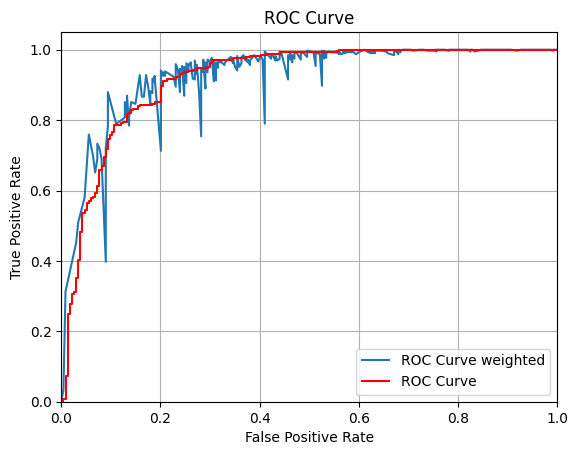

In [56]:
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points] 

#plot the roc curve
import matplotlib.pyplot as plt
plt.figure
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label="ROC Curve weighted")
plt.plot(test_roc[0].cpu(), test_roc[1].cpu(), label="ROC Curve", color='red')
#plt.fill_between(test_roc[0].cpu(), test_roc[1].cpu(), alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower right")
plt.show()

### Cost sensitive ROC built using the decision rule
* Calculate/assume the marginal probability P[Y=1]. Lets keep it 0.5, as varying the w will sweep across all the threshold values from 0 to 1.This will give exactly the conventional ROC curve
* Lets change the P[Y=1] value based on the actual probability in the training set
* Calculate the threshold

In [52]:
# number of samples of each class in training set
postive_count = sum(1 for _, label in train_dataset if label == 1)
negative_count = sum(1 for _, label in train_dataset if label == 0)

p = (postive_count) / (postive_count + negative_count)


fpr_weighted_fast = []
tpr_weighted_fast = []

#p = 0.5  # marginal probability of positive class

model_orig.eval()
wgt = np.linspace(0.001, 0.999, 500, endpoint=True)

# Wrap the outer loop with tqdm for the progress bar
for w in tqdm(wgt, desc="[Calculating FPR/TPR]", leave=True):
    all_predictions = []
    all_labels = []
    #b = w/(1 - w)
    #p = (b * postive_count) / (b * postive_count + negative_count)
    # Calculate the decision rule
    dec_rule = p * (1 - w) / (w * (1 - p) + p * (1 - w))
    with torch.no_grad():
        for inputs, labels in tqdm(
            test_loader, desc=f"[Test - pos_weight={pos_weight:.3f}]", leave=False
        ):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_orig(inputs)
            predictions = (torch.sigmoid(outputs) > dec_rule).float()  # Binary predictions
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    tn, fp, fn, tp = cm.ravel()
    test_accuracy = (tp + tn) / (tp + tn + fp + fn)
    test_precision = tp / (tp + fp) if (tp + fp) > 0 else float("nan")
    test_recall = tp / (tp + fn) if (tp + fn) > 0 else float("nan")
    test_f1 = (
        2 * (test_precision * test_recall) / (test_precision + test_recall)
        if (test_precision + test_recall) > 0
        else float("nan")
    )
    # print(f"Test Accuracy: {test_accuracy:.4f}")
    # print(f"Test Precision: {test_precision:.4f}")
    # print(f"Test Recall: {test_recall:.4f}")
    # print(f"Test F1-Score: {test_f1:.4f}")

    # Calculate FPR and TPR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else float("nan")
    tpr = tp / (tp + fn) if (tp + fn) > 0 else float("nan")

    fpr_weighted_fast.append(fpr)
    tpr_weighted_fast.append(tpr)


[Calculating FPR/TPR]: 100%|██████████| 500/500 [04:51<00:00,  1.72it/s]


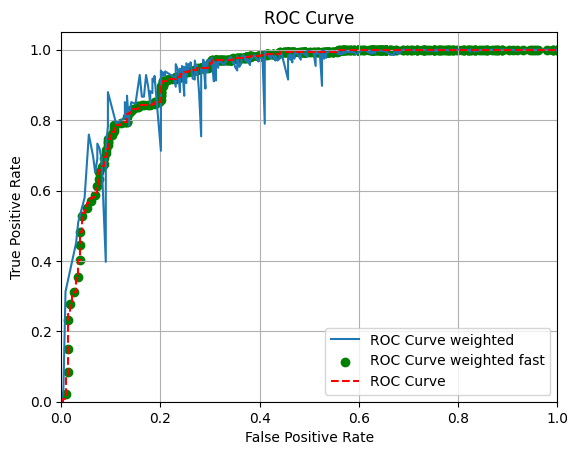

In [53]:
roc_points = sorted(zip(fpr_weighted_fast, tpr_weighted_fast))
fpr_weighted_sorted_fast = [p[0] for p in roc_points]
tpr_weighted_sorted_fast = [p[1] for p in roc_points] 

#plot the roc curve
import matplotlib.pyplot as plt
plt.figure
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label="ROC Curve weighted")
plt.scatter(fpr_weighted_sorted_fast, tpr_weighted_sorted_fast, label="ROC Curve weighted fast", color='green')
plt.plot(test_roc[0].cpu(), test_roc[1].cpu(), label="ROC Curve", color='red', linestyle='dashed')
#plt.fill_between(test_roc[0].cpu(), test_roc[1].cpu(), alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower right")
plt.show()